# Quantifying Data Distortion

Teng-Jui Lin

- Created: 2023-05-28
- Edited: 2024-08-10

In [1]:
from bar_constants import *
import bar_util as util
set_save_fig_rc()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Data Import and Processing

### Quantity annotations

In [2]:
bar_annot_df_list = []
for journal in JOURNALS:
    mistake_bar_annot_df_list = []
    for mistake in MISTAKES:
        # get filepaths of graph quantity annotation
        annot_df_ = pd.read_excel(os.path.join(f'data/misused_bar_graph_figures/{journal}/{mistake}', 'annotation.xlsx'), index_col=0)
        mistake_bar_annot_df_list.append(annot_df_)
    # construct journal-level annotation df
    journal_annot_df = pd.concat(mistake_bar_annot_df_list)
    bar_annot_df_list.append(journal_annot_df)
    
# construct overall df
bar_annot_df = pd.concat(bar_annot_df_list)
bar_annot_df

,DOI,Mistake,Fig ID,Journal,Quantity,Absolute/Relative,Measurement Type,Physical quantity I,Physical quantity II,Log transformation
Fig Index,,,,,,,,,,
10.1021:acsnano.2c07293_zero_fig1,10.1021:acsnano.2c07293,zero,1,acs_nano,Temperature (°C),Relative,Measured value,Temperature,Temperature,No
10.1021:acsnano.2c07436_zero_fig1,10.1021:acsnano.2c07436,zero,1,acs_nano,Hydroxy radicals scavenging (%),Relative,Percentage,Percentage,Percentage,No
10.1021:acsnano.2c07439_zero_fig1,10.1021:acsnano.2c07439,zero,1,acs_nano,Intracellular MFI (a.u.),Relative,Calculated value,Relative luminescence,Fluorescence,No
10.1021:acsnano.2c08153_zero_fig1,10.1021:acsnano.2c08153,zero,1,acs_nano,Wavelength shift (nm),Absolute,Measured value,Length,Length,No
10.1021:acsnano.2c08190_zero_fig1,10.1021:acsnano.2c08190,zero,1,acs_nano,Percentage of DCF fluorescence (%),Relative,Percentage,Percentage,Percentage,No
...,...,...,...,...,...,...,...,...,...,...
10.1126:science.adi2246_log_fig2,10.1126:science.adi2246,log,2,science,Relative fold change cs WT (normalized by GAPDH),Relative,Ratio,Ratio,Ratio,No
10.1126:science.adi2246_log_fig3,10.1126:science.adi2246,log,3,science,Relative gene expression (vs GAPDH),Relative,Ratio,Ratio,Ratio,No
10.1126:science.adi8885_log_fig1,10.1126:science.adi8885,log,1,science,KO/WT (log10),Relative,Ratio,Ratio,Ratio,10


### Bar-level data

In [3]:
X_LABEL = 'True Value'
Y_LABEL = 'Visualized Value'
ALPHA_MARK_LABEL = 'Mark Proportionality Constant'
ALPHA_DIFF_LABEL = 'Difference Proportionality Constant'

In [4]:
value_labels = [VAL_LABEL, VIZ_LABEL]
value_label_labels = [X_LABEL, Y_LABEL]

zero_bar_df_list = []
log_bar_df_list = []
for journal in JOURNALS:
    mistake_zero_bar_df_list = []
    mistake_log_bar_df_list = []
    for mistake in MISTAKES:
        # EXTRACT TRUE AND VISUALIZED VALUES
        for j, value_label in enumerate(value_labels):
            # get filepaths of digitized values in csv
            filepath = os.path.join(DATA_DIR, MISUSED_BAR_DIR, journal, mistake)
            filenames = os.listdir(filepath)
            filenames = pd.Series(filenames)
            filenames = filenames[filenames.str.contains(CSV_FILEEXT) & filenames.str.contains(value_label)]
            filenames = filenames.reset_index(drop=True)
            fignames = filenames.str.slice(stop=-8)
            fig_fullids = fignames.str.replace('fig', '')
            filepaths = filepath + os.sep + filenames
            # read individual csv
            raw_df_dict = {}
            for i, filepath in enumerate(filepaths):
                bar_df_ = pd.read_csv(filepath, header=None, index_col=0)
                bar_df_ = bar_df_.reset_index(drop=True)
                bar_df_.columns = [value_label_labels[j]]
                # # add metadata
                raw_df_dict[fignames[i]] = bar_df_
            
            # construct mistake-level df
            mistake_level_bar_df = pd.concat(raw_df_dict)
            if mistake == ZERO_SUBDIR:
                mistake_zero_bar_df_list.append(mistake_level_bar_df)
            elif mistake == LOG_SUBDIR:
                mistake_log_bar_df_list.append(mistake_level_bar_df)
            else:
                raise ValueError

    # construct journal-level bar df
    # zero
    journal_zero_bar_df = mistake_zero_bar_df_list[0].copy()
    journal_zero_bar_df[Y_LABEL] = mistake_zero_bar_df_list[1][Y_LABEL]
    journal_zero_bar_df[ALPHA_MARK_LABEL] = journal_zero_bar_df[Y_LABEL] / journal_zero_bar_df[X_LABEL]
    zero_bar_df_list.append(journal_zero_bar_df)
    # log
    journal_log_bar_df = mistake_log_bar_df_list[0].copy()
    journal_log_bar_df[Y_LABEL] = mistake_log_bar_df_list[1][Y_LABEL]
    journal_log_bar_df[ALPHA_MARK_LABEL] = journal_log_bar_df[Y_LABEL] / journal_log_bar_df[X_LABEL]
    log_bar_df_list.append(journal_log_bar_df)

# construct overall df
zero_bar_df = pd.concat(zero_bar_df_list)
log_bar_df = pd.concat(log_bar_df_list)
bar_df = pd.concat([zero_bar_df, log_bar_df])
bar_df

True Value  Visualized Value  \
10.1021:acsnano.3c07517_zero_fig2 0    1.000787          0.200787   
                                  1    1.469291          0.669291   
                                  2    1.264567          0.464567   
10.1021:acsnano.2c10352_zero_fig2 0   20.389610          0.259740   
                                  1   21.255411          0.281385   
...                                         ...               ...   
10.1126:science.ade3483_log_fig1  0  593.139572          0.924386   
                                  1  507.112096          0.901701   
                                  2    7.768894          0.296786   
                                  3    6.061899          0.260870   
                                  4    4.489251          0.217391   

                                     Mark Proportionality Constant  
10.1021:acsnano.3c07517_zero_fig2 0                       0.200629  
                                  1                       0.455520  
                                  2                       0.367372  
10.1021:acsnano.2c10352_zero_fig2 0                       0.012739  
                                  1                       0.013238  
...                                                            ...  
10.1126:science.ade3483_log_fig1  0                       0.001558  
                                  1                       0.001778  
                                  2                       0.038202  
                                  3                       0.043034  
                                  4                       0.048425  

[19760 rows x 3 columns]

### Pairwise permutation-level metric

In [5]:
L_df_list = []
fig_ids = np.unique(bar_df.index.get_level_values(0))
for i, fig_id in enumerate(fig_ids):
    df = bar_df[bar_df.index.get_level_values(0) == fig_id]
    
    # generate permutations and their respective x, y values
    L_df_ = pd.concat(
        [
            util.perm_rel_change(df, X_LABEL), 
            util.perm_rel_change(df, Y_LABEL),
        ], 
        axis=1
    )
    L_df_.columns = ['x_1', 'x_2', 'y_1', 'y_2']

    # store bar id
    L_df_[['Bar 1 ID', 'Bar 2 ID']] = util.perm_rel_change(bar_df[bar_df.index.get_level_values(0) == fig_id].reset_index(), 'level_1')
    
    # compute lie factor of relative change
    L_df_['E_x_12'] = (L_df_['x_1'] - L_df_['x_2']) / L_df_['x_2']
    L_df_['E_y_12'] = (L_df_['y_1'] - L_df_['y_2']) / L_df_['y_2']
    L_df_['L_12'] = L_df_['E_y_12'] / L_df_['E_x_12']
    L_df_['log L_12'] = np.log10(L_df_['L_12'])

    # compute GDI
    L_df_['GDI_12'] = 100 * (L_df_['L_12'] - 1)

    # compute lie factor of fold change
    L_df_['F_12'] = (L_df_['x_1'] / L_df_['x_2']) / (L_df_['y_1'] / L_df_['y_2'])
    L_df_['log F_12'] = np.log10(L_df_['F_12'])

    # compute RGD
    L_df_['RGD_12'] = L_df_['L_12'] - 1

    # add meta data
    L_df_['Fig Index'] = df.index.get_level_values(0)[0]
    L_df_list.append(L_df_)
L_df = pd.concat(L_df_list, ignore_index=True)
L_df = L_df.set_index('Fig Index')
L_df

,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12
Fig Index,,,,,,,,,,,,,,
10.1002:btm2.10487_log_fig1,0.941271,17.800504,0.352212,0.803540,0,1,-0.947121,-0.561674,0.593033,-0.226921,-40.696707,0.120638,-0.918515,-0.406967
10.1002:btm2.10487_log_fig1,0.941271,0.297195,0.352212,0.175221,0,2,2.167186,1.010101,0.466089,-0.331531,-53.391128,1.575635,0.197456,-0.533911
10.1002:btm2.10487_log_fig1,0.941271,3.977009,0.352212,0.573451,0,3,-0.763322,-0.385802,0.505426,-0.296343,-49.457437,0.385345,-0.414150,-0.494574
10.1002:btm2.10487_log_fig1,17.800504,0.941271,0.803540,0.352212,1,0,17.911138,1.281407,0.071542,-1.145436,-92.845753,8.289243,0.918515,-0.928458
10.1002:btm2.10487_log_fig1,17.800504,0.297195,0.803540,0.175221,1,2,58.895093,3.585859,0.060886,-1.215486,-93.911448,13.060824,1.115971,-0.939114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1126:scitranslmed.adi9867_log_fig2,1331.015174,786.004146,0.795732,0.742378,2,1,0.693395,0.071869,0.103647,-0.984441,-89.635255,1.579853,0.198617,-0.896353
10.1126:scitranslmed.adi9867_log_fig2,1331.015174,437.041699,0.795732,0.682927,2,3,2.045511,0.165179,0.080752,-1.092848,-91.924825,2.613772,0.417268,-0.919248
10.1126:scitranslmed.adi9867_log_fig2,437.041699,2504.337233,0.682927,0.859756,3,0,-0.825486,-0.205674,0.249155,-0.603531,-75.084527,0.219701,-0.658169,-0.750845


### Graph-level metric

In [6]:
grouped_alpha = (bar_df[ALPHA_MARK_LABEL]).groupby(bar_df.index.get_level_values(0))
grouped_alpha_inverse = (1 / bar_df[ALPHA_MARK_LABEL]).groupby(bar_df.index.get_level_values(0))

In [7]:
cv_df = grouped_alpha.std() / grouped_alpha.mean()
cv_df = cv_df.to_frame()
cv_df.columns = ['CV']
cv_df['log CV'] = np.log10(cv_df['CV'])

cv_df['RCVQ'] = 0.75 * (grouped_alpha.quantile(0.75) - grouped_alpha.quantile(0.25)) / grouped_alpha.median()
cv_df['log RCVQ'] = np.log10(cv_df['RCVQ'])

cv_df['RCVM'] = 1.4826 * grouped_alpha.agg(lambda pop: np.median(np.abs(pop - np.median(pop)))) / grouped_alpha.median()
cv_df['log RCVM'] = np.log10(cv_df['RCVM'])

# tag meta data
cv_df = cv_df.join(bar_annot_df['Mistake'].to_frame())
cv_df

,CV,log CV,RCVQ,log RCVQ,RCVM,log RCVM,Mistake
10.1002:btm2.10487_log_fig1,0.845068,-0.073108,0.892998,-0.049149,0.941095,-0.026366,log
10.1002:btm2.10487_log_fig2,1.048477,0.020559,1.290353,0.110709,1.235633,0.091889,log
10.1002:btm2.10499_zero_fig1,0.457477,-0.339630,0.570541,-0.243713,0.600403,-0.221557,zero
10.1002:btm2.10499_zero_fig2,0.139314,-0.856007,0.137966,-0.860228,0.129917,-0.886333,zero
10.1002:btm2.10499_zero_fig3,0.139831,-0.854397,0.153909,-0.812737,0.110864,-0.955210,zero
...,...,...,...,...,...,...,...
10.1126:scitranslmed.adi7244_zero_fig1,0.198204,-0.702888,0.105113,-0.978342,0.207788,-0.682379,zero
10.1126:scitranslmed.adi7244_zero_fig2,0.701399,-0.154035,0.371973,-0.429488,0.735316,-0.133526,zero
10.1126:scitranslmed.adi7244_zero_fig3,0.468870,-0.328947,0.248656,-0.604401,0.491543,-0.308438,zero
10.1126:scitranslmed.adi9867_log_fig1,0.242860,-0.614644,0.167586,-0.775761,0.182277,-0.739267,log


## Data Visualization

### Utility functions

In [8]:
def label_stats(ax, pvalue, gamma, x=0.5, y=0.85, color='k', two_sample=True):
    line_y_offset = 0.03
    line_x_offset = 0.15
    if pvalue < 0.001:
        ax.text(
            x, 
            y,
            '$\it{P}$ = ' + f'{pvalue:.1e}' + '\n$\gamma$ = ' + f'{gamma:.2}',
            ha='center',
            transform=ax.transAxes,
            color=color,
        )
    else:
        ax.text(
            x, 
            y,
            '$\it{P}$ = ' + f'{pvalue:.2}' + '\n$\gamma$ = ' + f'{gamma:.2}',
            ha='center',
            transform=ax.transAxes,
            color=color,
        )
    if two_sample:
        ax.axhline(
            (y - line_y_offset) * ax.get_ylim()[1],
            x - line_x_offset, 
            x + line_x_offset,
            color=color,
            lw=1,
        )

### Metrics vs. mistake types

#### Pairwise-permutation metrics vs. mistake types

n = 747 Zeroing
n = 385 Log
(1132, 18)
Visualization excluded outlier 2/1132 = 0.0017667844522968198
n = 747 Zeroing
n = 385 Log
(1132, 18)
Visualization excluded outlier 7/1132 = 0.006183745583038869


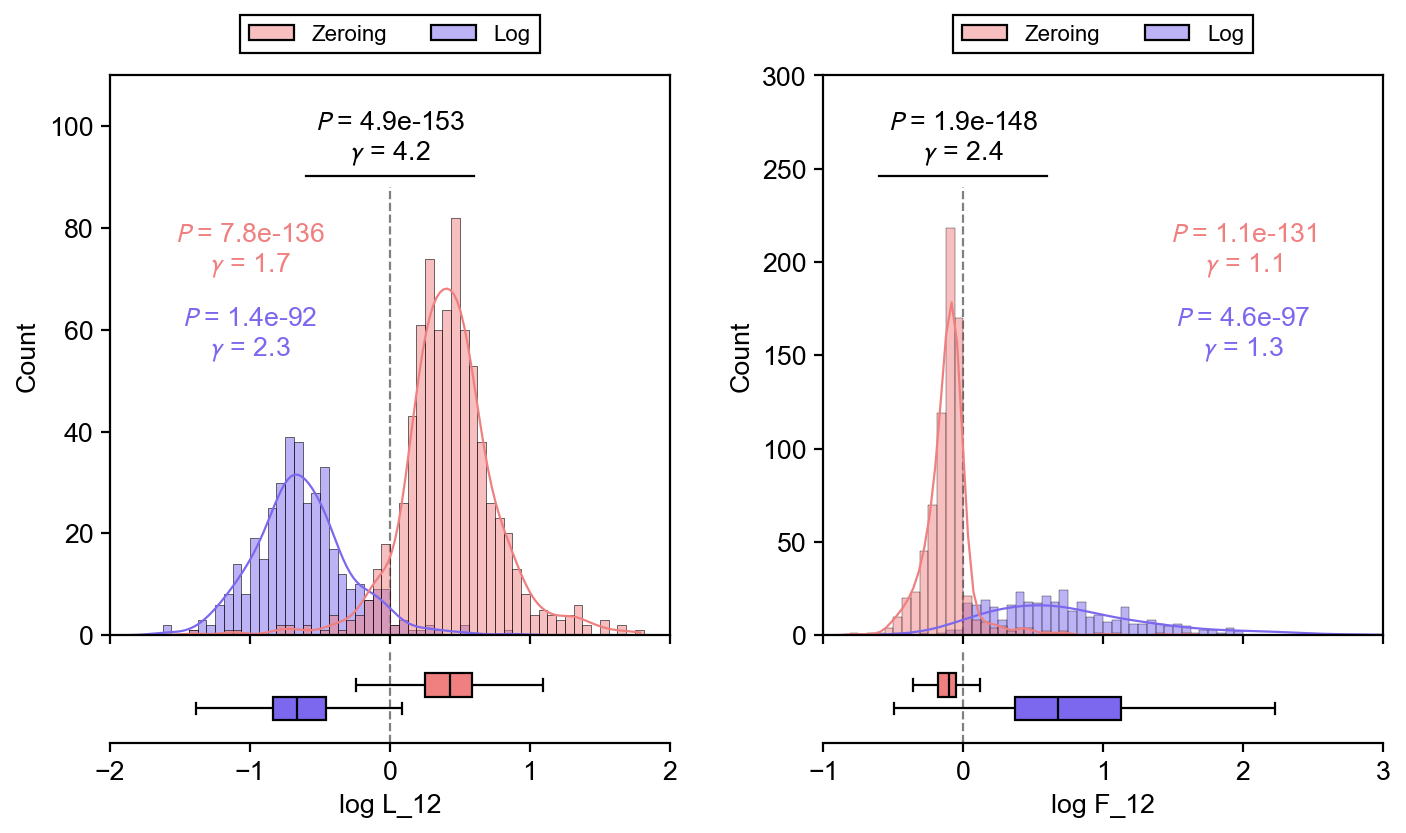

In [9]:
bins = np.arange(-2, 2 + 0.0625, 0.0625)

fig, axs = plt.subplots(2, 2, figsize=(9, 5), height_ratios=[6, 1], sharex='col')
ax_box_rel = axs[1, 0]
ax_hist_rel = axs[0, 0]
ax_box_abs = axs[1, 1]
ax_hist_abs = axs[0, 1]

## subplot 1
property = 'log L_12'
# define visualization domain
xmin = -2
xmax = 2
# eliminate bar-level bias by groupby graphs
plot_df = L_df.groupby(L_df.index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Physical quantity I']])
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_rel,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_rel,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_ylim(0, 110)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
)

# label one sample location
one_sample_zero_x = 0.25
one_sample_log_x = one_sample_zero_x
one_sample_zero_y = 0.65
one_sample_y_offset = 0.15
one_sample_log_y = one_sample_zero_y - one_sample_y_offset

# label one-sample stats (zero)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[zero_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    [0]
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
    x=one_sample_zero_x,
    y=one_sample_zero_y,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

# label one-sample stats (log)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[log_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[log_cond, property],
    [0]
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
    x=one_sample_log_x,
    y=one_sample_log_y,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

## subplot 2
property = 'log F_12'
# define visualization domain
xmin = -1
xmax = 3
# eliminate bar-level bias by groupby graphs
plot_df = util.keep_finite(L_df)
plot_df = plot_df[plot_df['x_1'] > plot_df['x_2']].groupby(plot_df[plot_df['x_1'] > plot_df['x_2']].index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Physical quantity I']])  
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_abs,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_abs,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_ylim(0, 300)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=0.25,
    y=0.85
)

# label one sample location
one_sample_zero_x = 0.75
one_sample_log_x = one_sample_zero_x
one_sample_zero_y = 0.65
one_sample_y_offset = 0.15
one_sample_log_y = one_sample_zero_y - one_sample_y_offset

# label one-sample stats (zero)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[zero_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    [0]
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=one_sample_zero_x,
    y=one_sample_zero_y,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

# label one-sample stats (log)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[log_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[log_cond, property],
    [0]
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=one_sample_log_x,
    y=one_sample_log_y,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

# common labels by row and col
for i in range(2):
    axs[0, i].set_box_aspect(1)
    axs[0, i].axvline(0, 0, 0.8, color='gray', lw=1, ls='--', zorder=0)
    
    axs[1, i].set_box_aspect(1/6)
    axs[1, i].axis()
    axs[1, i].spines['left'].set_linewidth(0)
    axs[1, i].spines['right'].set_linewidth(0)
    axs[1, i].spines['top'].set_linewidth(0)
    axs[1, i].tick_params(
        axis='y',
        which='both',
        left=False,
    )
    axs[1, i].axvline(0, 0, 1, color='gray', lw=1, ls='--', zorder=0)

plt.tight_layout(pad=0)

#### Graph-level metrics vs. mistake types

log RCVQ
n = 732 Zeroing
n = 388 Log
(1120, 10)
Visualization excluded outlier 8/1120 = 0.007142857142857143

log RCVM
n = 732 Zeroing
n = 388 Log
(1120, 10)
Visualization excluded outlier 5/1120 = 0.004464285714285714



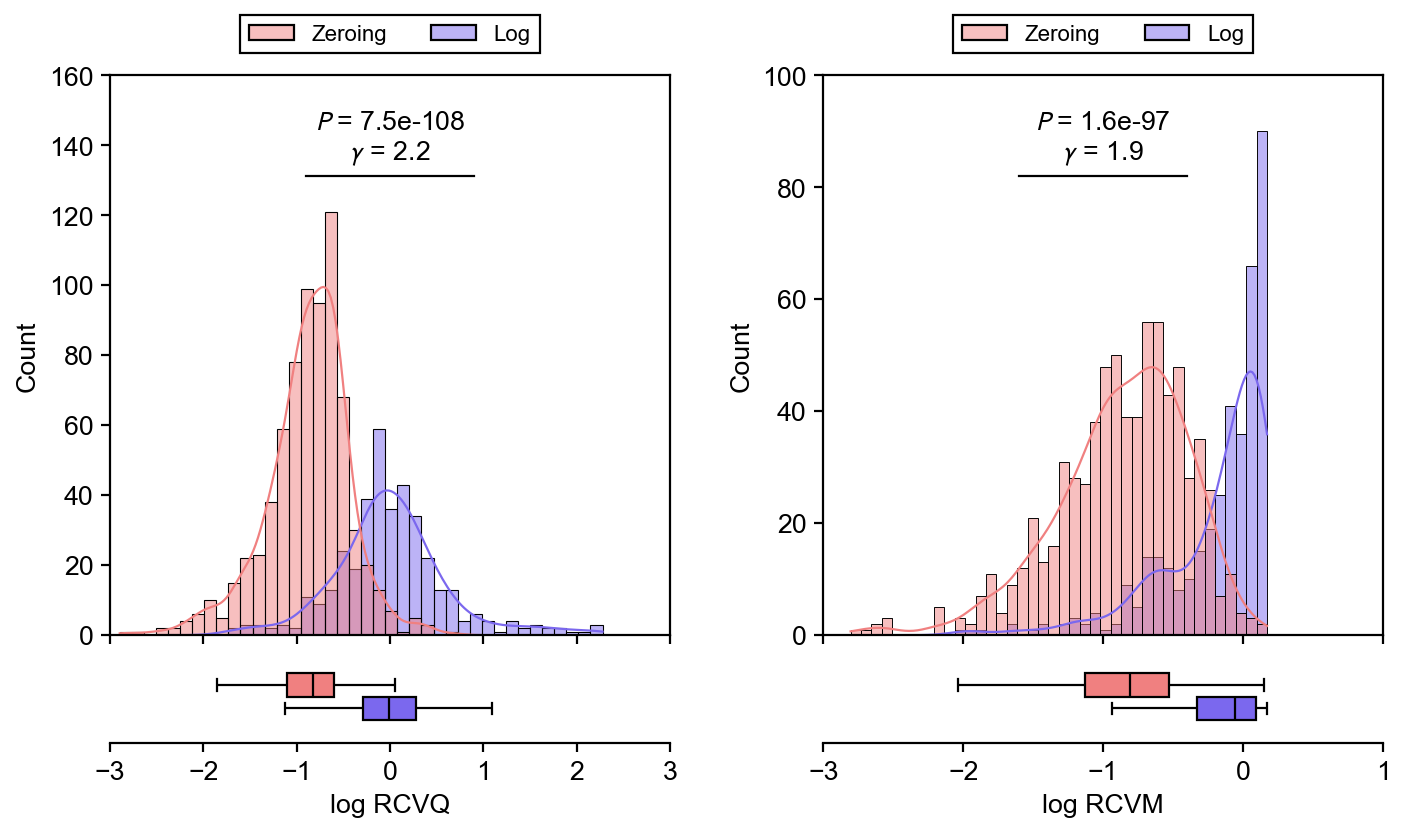

In [10]:
property_list = [
    'RCVQ',
    'RCVM',
]
row = 2
col = len(property_list)
scale = 3
fig, axs = plt.subplots(row, col, figsize=(9, 5), height_ratios=[6, 1], sharex='col')

axs[0, 0].set_ylim(0, 160)
axs[0, 1].set_ylim(0, 100)
axs[0, 0].set_xlim(-3, 3)
axs[0, 1].set_xlim(-3, 1)

for col_i in range(col):
    property = property_list[col_i]
    log_property = f'log {property}'
    #
    xmin, xmax = axs[0, col_i].get_xlim()
    # bins = np.arange(xmin, xmax + 0.0625, 0.0625)
    plot_df = util.keep_finite(cv_df)
    # tag on text properties
    plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Physical quantity I']])  
    # eliminate graph-level bias by groupby physical quantities
    plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
    plot_df = plot_df.reset_index()
    # define zero and log conditions
    zero_cond = (plot_df['Mistake'] == 'zero')
    log_cond = (plot_df['Mistake'] == 'log')
    # print info
    print(log_property)
    print(f"n = {sum(zero_cond)} Zeroing")
    print(f"n = {sum(log_cond)} Log")
    print(plot_df.shape)
    
    excluded_df = plot_df[(
        ((plot_df[log_property] > xmax) | (plot_df[log_property] < xmin))
    )]
    print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")
    print()
    
    ## first row
    hist = sns.histplot(
        plot_df[
            (plot_df[log_property] >= xmin)
            & (plot_df[log_property] <= xmax)
        ],
        x=log_property,
        hue='Mistake',
        bins=40,
        kde=True,
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        ax=axs[0, col_i],
    )
    # configure legend
    sns.move_legend(
        hist, 
        loc='lower center', 
        **dict(
            bbox_to_anchor=(0.5, 1.02),
            title='',
            labels=[ZERO_LABEL, LOG_LABEL],
            ncol=2,
        )
    )

    # second row
    box = sns.boxplot(
        plot_df,
        x=log_property,
        hue='Mistake',
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        width=0.5,
        legend=False,
        showfliers=False,
        saturation=1,
        linecolor='k',
        ax=axs[1, col_i],
    )
    
    # label stats
    stat, pvalue = scipy.stats.mannwhitneyu(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    gamma = util.get_gamma(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    label_stats(
        axs[0, col_i], 
        pvalue, 
        gamma,
    )

for col_i in range(col):
    for row_i in range(row):
        axs[0, col_i].set_box_aspect(1)
        axs[1, col_i].set_box_aspect(1/6)
        axs[1, col_i].spines['left'].set_linewidth(0)
        axs[1, col_i].spines['right'].set_linewidth(0)
        axs[1, col_i].spines['top'].set_linewidth(0)
        axs[1, col_i].tick_params(
            axis='y',
            which='both',
            left=False,
        )
plt.tight_layout(pad=0)

### Compiled graph

n = 747 Zeroing
n = 385 Log
(1132, 18)
Visualization excluded outlier 2/1132 = 0.0017667844522968198
n = 747 Zeroing
n = 385 Log
(1132, 18)
Visualization excluded outlier 7/1132 = 0.006183745583038869
log RCVQ
n = 732 Zeroing
n = 388 Log
(1120, 10)
Visualization excluded outlier 8/1120 = 0.007142857142857143

log RCVM
n = 732 Zeroing
n = 388 Log
(1120, 10)
Visualization excluded outlier 5/1120 = 0.004464285714285714



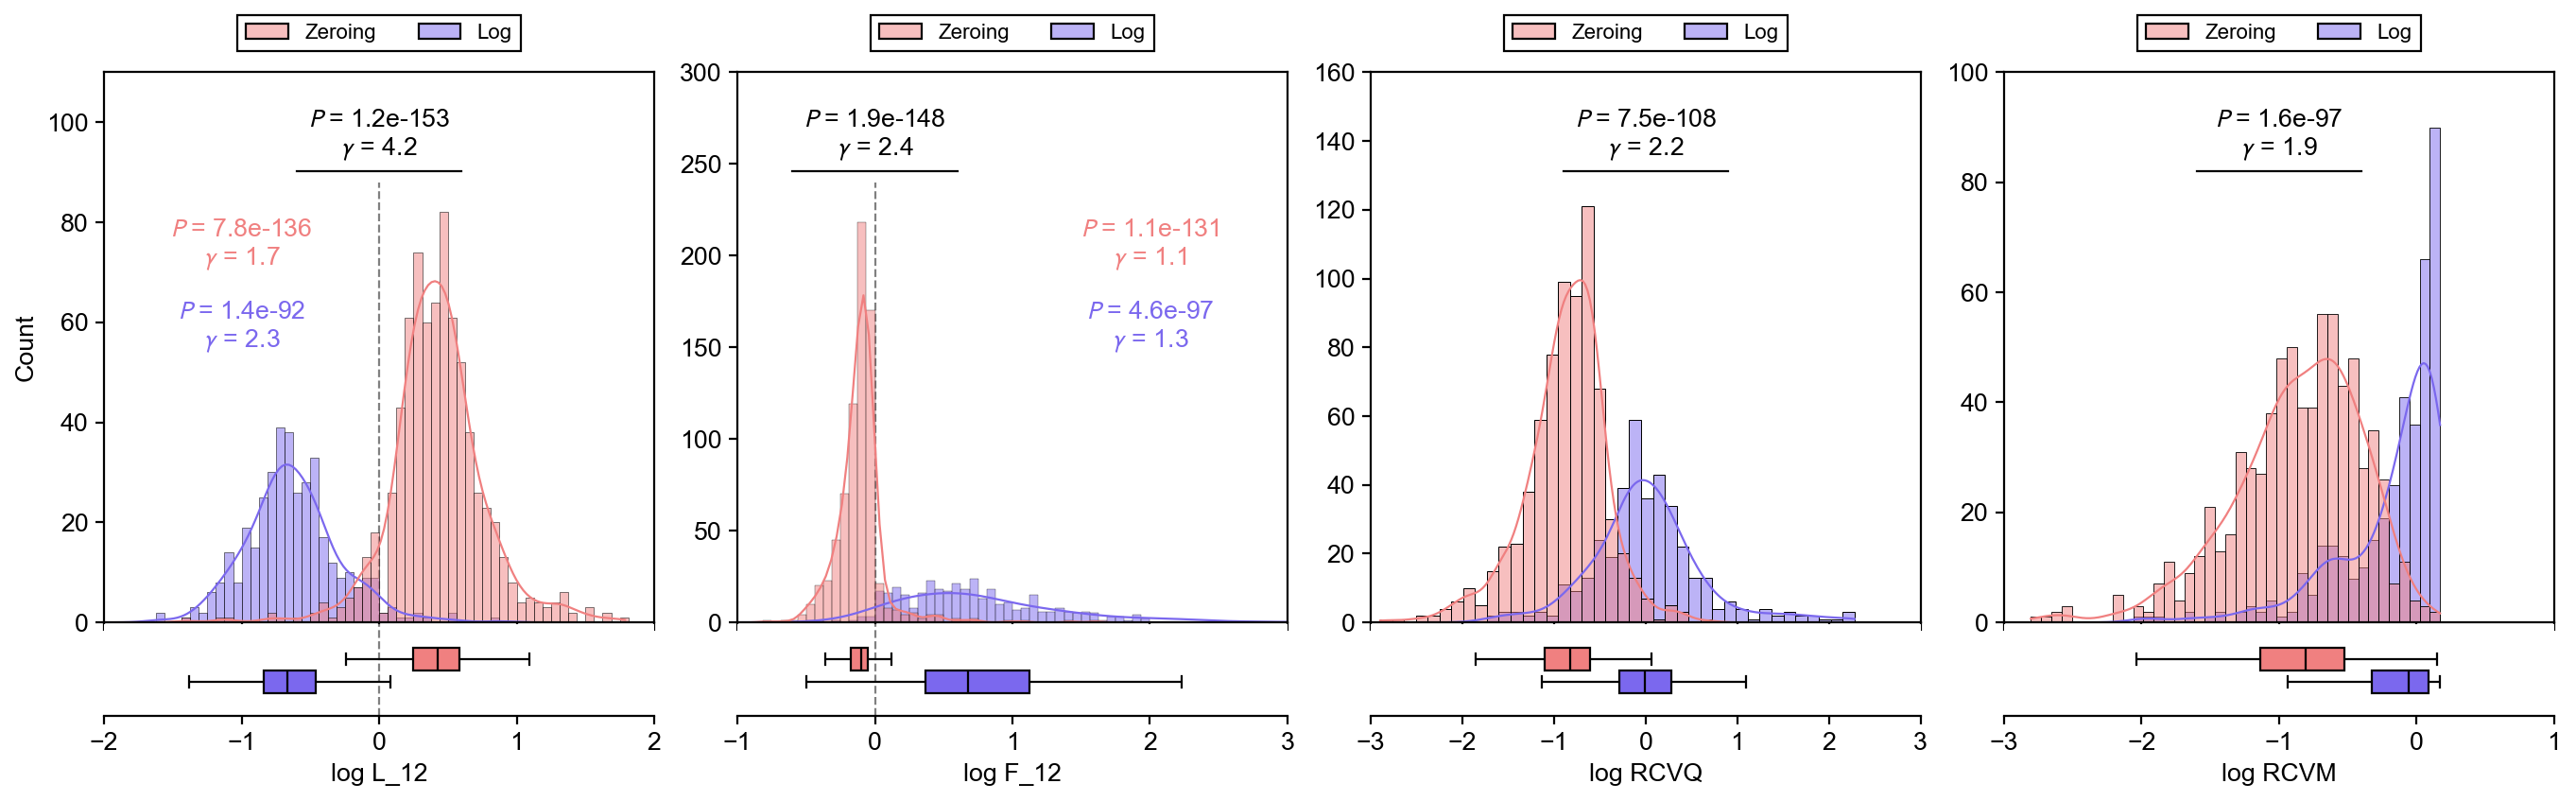

In [11]:
bins = np.arange(-2, 2 + 0.0625, 0.0625)

fig, axs = plt.subplots(2, 4, figsize=(17, 5), height_ratios=[6, 1], sharex='col')
ax_box_rel = axs[1, 0]
ax_hist_rel = axs[0, 0]
ax_box_abs = axs[1, 1]
ax_hist_abs = axs[0, 1]

## subplot 1
property = 'log L_12'
# define visualization domain
xmin = -2
xmax = 2
# eliminate bar-level bias by groupby graphs
plot_df = L_df.groupby(L_df.index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Physical quantity I']])
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_rel,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_rel,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_ylim(0, 110)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
)

# label one sample location
one_sample_zero_x = 0.25
one_sample_log_x = one_sample_zero_x
one_sample_zero_y = 0.65
one_sample_y_offset = 0.15
one_sample_log_y = one_sample_zero_y - one_sample_y_offset

# label one-sample stats (zero)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[zero_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    [0]
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
    x=one_sample_zero_x,
    y=one_sample_zero_y,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

# label one-sample stats (log)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[log_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[log_cond, property],
    [0]
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
    x=one_sample_log_x,
    y=one_sample_log_y,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

## subplot 2
property = 'log F_12'
# define visualization domain
xmin = -1
xmax = 3
# eliminate bar-level bias by groupby graphs
plot_df = util.keep_finite(L_df)
plot_df = plot_df[plot_df['x_1'] > plot_df['x_2']].groupby(plot_df[plot_df['x_1'] > plot_df['x_2']].index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Physical quantity I']])  
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_abs,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_abs,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_ylim(0, 300)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=0.25,
    y=0.85
)

# label one sample location
one_sample_zero_x = 0.75
one_sample_log_x = one_sample_zero_x
one_sample_zero_y = 0.65
one_sample_y_offset = 0.15
one_sample_log_y = one_sample_zero_y - one_sample_y_offset

# label one-sample stats (zero)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[zero_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    [0]
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=one_sample_zero_x,
    y=one_sample_zero_y,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

# label one-sample stats (log)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[log_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[log_cond, property],
    [0]
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=one_sample_log_x,
    y=one_sample_log_y,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

# common labels by row and col
for i in range(2):
    axs[0, i].set_box_aspect(1)
    axs[0, i].axvline(0, 0, 0.8, color='gray', lw=1, ls='--', zorder=0)
    
    axs[1, i].set_box_aspect(1/6)
    axs[1, i].axis()
    axs[1, i].spines['left'].set_linewidth(0)
    axs[1, i].spines['right'].set_linewidth(0)
    axs[1, i].spines['top'].set_linewidth(0)
    axs[1, i].tick_params(
        axis='y',
        which='both',
        left=False,
    )
    axs[1, i].axvline(0, 0, 1, color='gray', lw=1, ls='--', zorder=0)


# subplot 3, 4
axs[0, 2].set_ylim(0, 160)
axs[0, 3].set_ylim(0, 100)
axs[0, 2].set_xlim(-3, 3)
axs[0, 3].set_xlim(-3, 1)

property_list = [
    'RCVQ',
    'RCVM',
]
for i, col_i in enumerate(range(2, 2+col)):
    property = property_list[i]
    log_property = f'log {property}'
    #
    xmin, xmax = axs[0, col_i].get_xlim()
    # bins = np.arange(xmin, xmax + 0.0625, 0.0625)
    plot_df = util.keep_finite(cv_df)
    # tag on text properties
    plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Physical quantity I']])  
    # eliminate graph-level bias by groupby physical quantities
    plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
    plot_df = plot_df.reset_index()
    # define zero and log conditions
    zero_cond = (plot_df['Mistake'] == 'zero')
    log_cond = (plot_df['Mistake'] == 'log')
    # print info
    print(log_property)
    print(f"n = {sum(zero_cond)} Zeroing")
    print(f"n = {sum(log_cond)} Log")
    print(plot_df.shape)
    
    excluded_df = plot_df[(
        ((plot_df[log_property] > xmax) | (plot_df[log_property] < xmin))
    )]
    print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")
    print()
    
    ## first row
    hist = sns.histplot(
        plot_df[
            (plot_df[log_property] >= xmin)
            & (plot_df[log_property] <= xmax)
        ],
        x=log_property,
        hue='Mistake',
        bins=40,
        kde=True,
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        ax=axs[0, col_i],
    )
    # configure legend
    sns.move_legend(
        hist, 
        loc='lower center', 
        **dict(
            bbox_to_anchor=(0.5, 1.02),
            title='',
            labels=[ZERO_LABEL, LOG_LABEL],
            ncol=2,
        )
    )

    # second row
    box = sns.boxplot(
        plot_df,
        x=log_property,
        hue='Mistake',
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        width=0.5,
        legend=False,
        showfliers=False,
        saturation=1,
        linecolor='k',
        ax=axs[1, col_i],
    )
    
    # label stats
    stat, pvalue = scipy.stats.mannwhitneyu(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    gamma = util.get_gamma(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    label_stats(
        axs[0, col_i], 
        pvalue, 
        gamma,
    )

for col_i in range(2, 2+col):
    axs[0, col_i].set_box_aspect(1)
    axs[1, col_i].set_box_aspect(1/6)
    axs[1, col_i].spines['left'].set_linewidth(0)
    axs[1, col_i].spines['right'].set_linewidth(0)
    axs[1, col_i].spines['top'].set_linewidth(0)
    axs[1, col_i].tick_params(
        axis='y',
        which='both',
        left=False,
    )

for i in range(1, 4):
    axs[0, i].set_ylabel('')

plt.tight_layout(pad=0)

### Metrics vs. physical quantity, grouped by mistake types

#### Absolute/Relative

(1133, 19)
zero: pvalue = 0.6557194167590146, gamma = 0.033621220800808184
log: pvalue = 9.078643110327315e-07, gamma = 0.5216854665023324
(1133, 19)
zero: pvalue = 0.3444646856258593, gamma = 0.08293704524519924
log: pvalue = 0.08781993978279395, gamma = 0.1380374727812762
(1121, 11)
zero: pvalue = 0.04949673838911666, gamma = 0.17739502282166192
log: pvalue = 0.3379403519288735, gamma = 0.11929539805839633


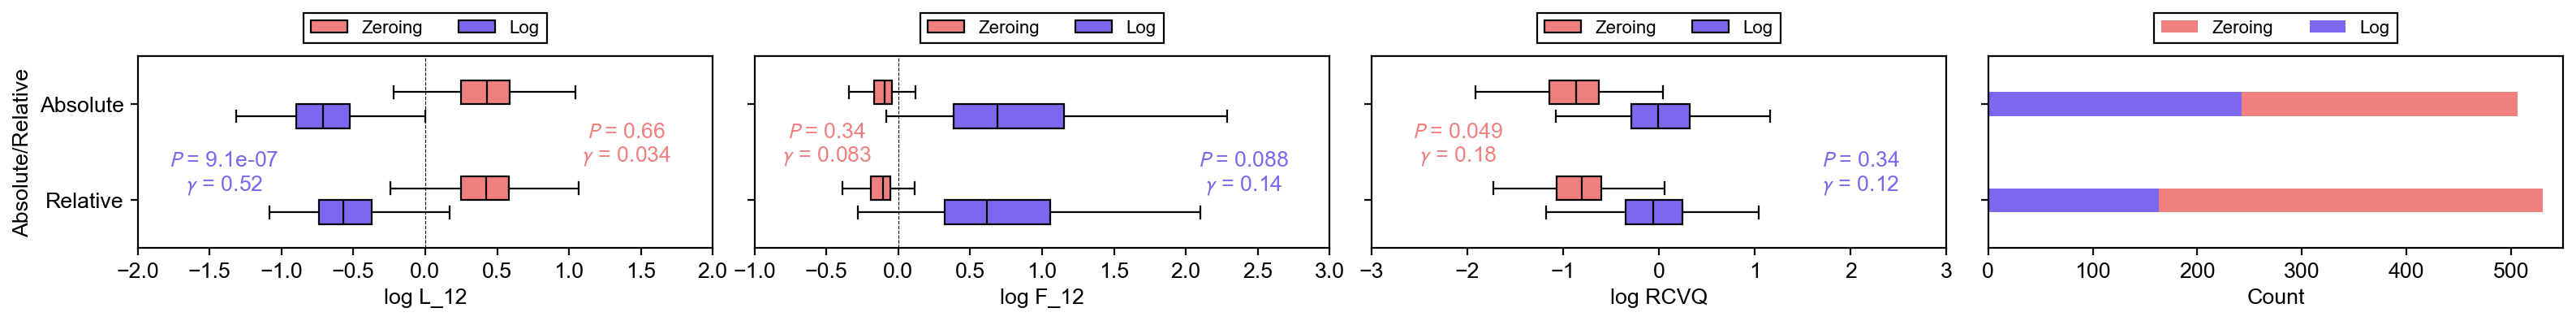

In [12]:
row = 1
col = 4
scale = 3
fig, axs = plt.subplots(row, col, figsize=(20, 5), sharey=True, width_ratios=[1, 1, 1, 1])

## subplot 1
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median().reset_index()
print(plot_df.shape)

property = 'log L_12'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')
stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
print(f'zero: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[0], 
    pvalue, 
    gamma,
    x=0.85,
    y=0.45,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
print(f'log: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[0], 
    pvalue, 
    gamma,
    x=0.15,
    y=0.3,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Absolute/Relative',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 2
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median().reset_index()
print(plot_df.shape)

property = 'log F_12'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')
stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
print(f'zero: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[1], 
    pvalue, 
    gamma,
    x=0.125,
    y=0.45,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
print(f'log: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[1], 
    pvalue, 
    gamma,
    x=0.85,
    y=0.3,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Absolute/Relative',
    hue='Mistake',
    ax=axs[1],
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 3
plot_df = util.keep_finite(cv_df)
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Physical quantity I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
plot_df = plot_df.reset_index()
print(plot_df.shape)

property = 'log RCVQ'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')
stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
print(f'zero: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[2], 
    pvalue, 
    gamma,
    x=0.15,
    y=0.45,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
print(f'log: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[2], 
    pvalue, 
    gamma,
    x=0.85,
    y=0.3,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

box = sns.boxplot(
    plot_df,
    x=property, 
    y='Absolute/Relative',
    hue='Mistake',
    ax=axs[2],
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 4
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.cumsum(axis=1).stack().reset_index(name='Count')
plot_df = df.copy()
# df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
# df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0]
# df.name = 'Count'
# df = df.to_frame().reset_index()
# plot_df = df.copy()
# df = bar_annot_df.groupby(['DOI', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
# df = df.groupby(['Absolute/Relative']).count().iloc[:, 0]
# df.name = 'Count'
# df = df.to_frame().reset_index()
# plot_df = df.copy()

bar = sns.barplot(
    data=plot_df,
    x='Count',
    y='Absolute/Relative',
    hue='Mistake',
    orient='h',
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    # palette=['lightgray'],
    dodge=False,
    saturation=1,
    width=0.25,
    ax=axs[3],
)
# configure legend
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 5
# df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
# df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
# df = df.set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
# df.columns = df.columns.get_level_values(1)
# df = df.div(df.sum(axis=1), axis=0) * 100
# df = df.cumsum(axis=1).stack().reset_index(name='Percentage')
# plot_df = df.copy()

# bar = sns.barplot(
#     plot_df,
#     x='Percentage',
#     y='Absolute/Relative',
#     hue='Mistake',
#     order=['Absolute', 'Relative'],
#     hue_order=['zero', 'log'],
#     palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
#     dodge=False,
#     saturation=1,
#     width=0.25,
#     ax=axs[4],
# )
# sns.move_legend(
#     bar, 
#     loc='lower center', 
#     **dict(
#         bbox_to_anchor=(0.5, 1.02),
#         title='',
#         labels=[ZERO_LABEL, LOG_LABEL],
#         ncol=2,
#     )
# )

for i in range(2):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
for i in range(4):
    axs[i].set_box_aspect(1/3)

axs[0].set_xlim(-2, 2)
axs[1].set_xlim(-1, 3)
axs[2].set_xlim(-3, 3)
axs[3].set_xlim(0, 550)
plt.tight_layout()

#### Physical quantity II

In [13]:
# order by the 5th subplot
# in ascending fraction of zeroing (descending fraction of log)
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index()
df = df.groupby(['Physical quantity II', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Physical quantity II').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
order = df.sort_values('zero', ascending=True).index

(1112, 19)
(1112, 19)
(1085, 11)


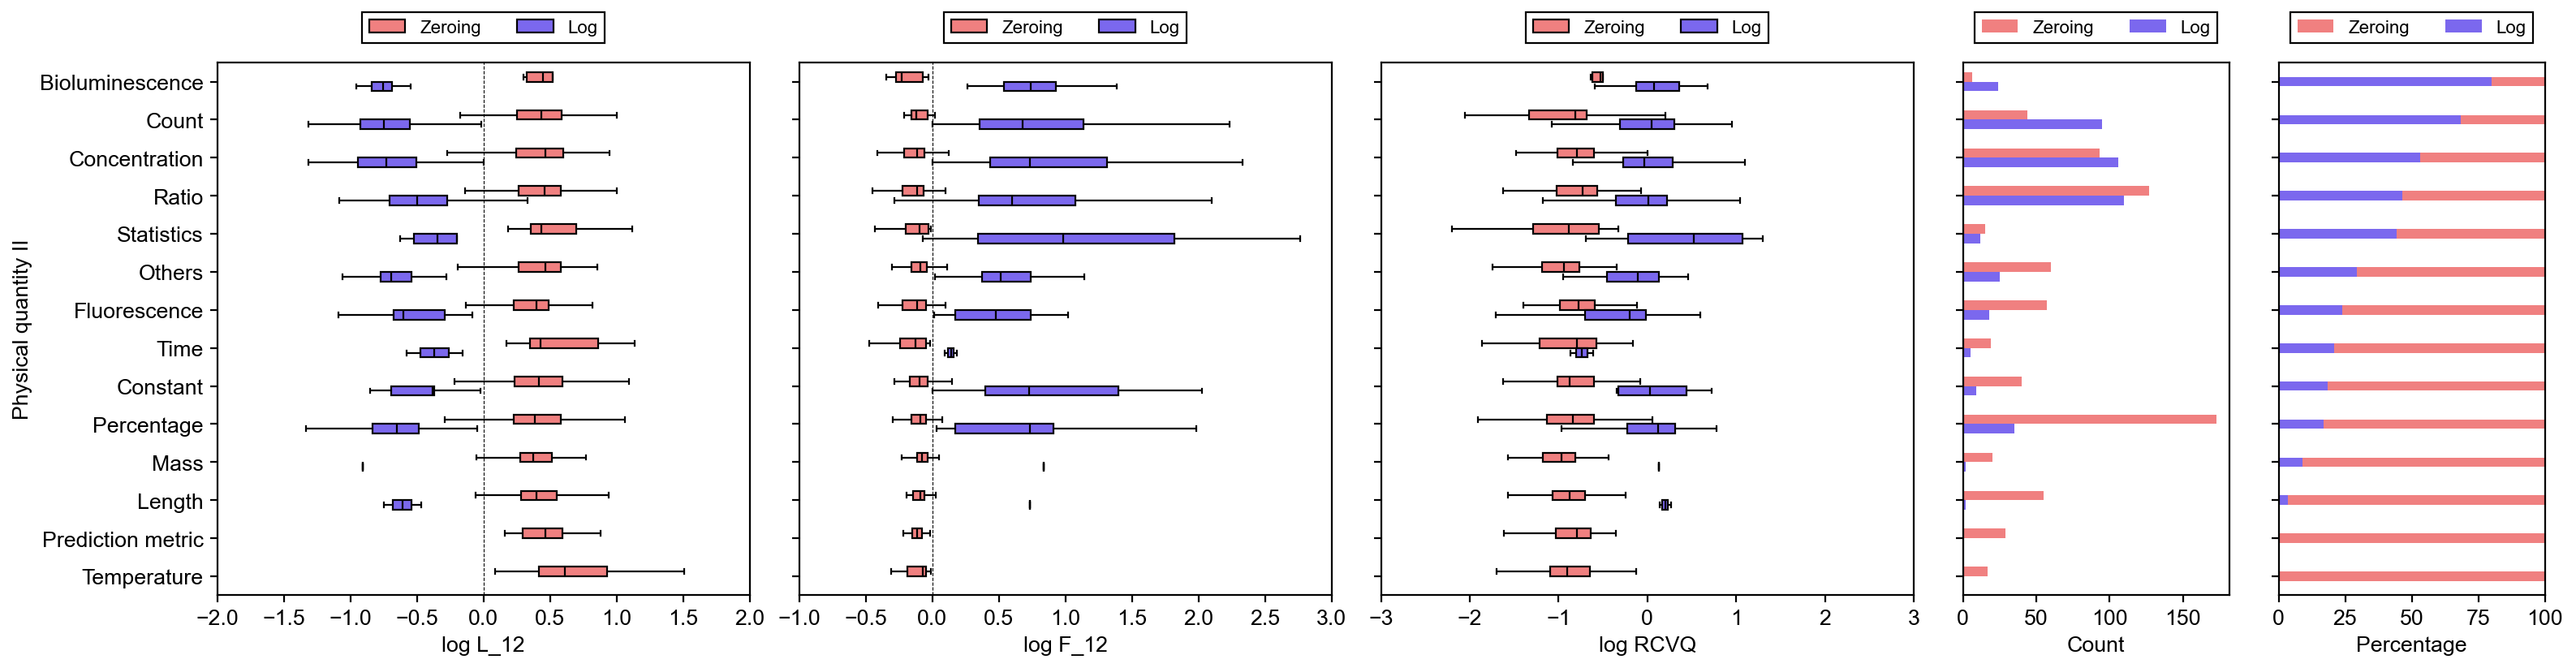

In [14]:
row = 1
col = 5
scale = 3
fig, axs = plt.subplots(row, col, figsize=(20, 5), sharey=True, width_ratios=[1, 1, 1, 0.5, 0.5])

## subplot 1
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Physical quantity II',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    legend=True,
    showfliers=False,
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 2
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Physical quantity II',
    hue='Mistake', 
    ax=axs[1],
    width=0.5,
    legend=True,
    showfliers=False,
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 3
plot_df = util.keep_finite(cv_df)
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median()
plot_df = plot_df.reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log RCVQ', 
    y='Physical quantity II',
    hue='Mistake', 
    ax=axs[2],
    width=0.5,
    legend=True,
    showfliers=False,
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 4
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index()
df = df.groupby(['Physical quantity II', 'Mistake']).count().iloc[:, 0]
df.name = 'Count'
df = df.to_frame().reset_index()
plot_df = df.copy()

bar = sns.barplot(
    data=plot_df,
    x='Count',
    y='Physical quantity II',
    hue='Mistake',
    orient='h',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    width=0.5,
    ax=axs[3],
)
# configure legend
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 5
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index()
df = df.groupby(['Physical quantity II', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Physical quantity II').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
df = df.cumsum(axis=1).stack().reset_index(name='Percentage')
plot_df = df.copy()

bar = sns.barplot(
    plot_df,
    x='Percentage',
    y='Physical quantity II',
    hue='Mistake',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    dodge=False,
    saturation=1,
    width=0.25,
    ax=axs[4],
)
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

for i in range(2):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
for i in range(0, 3):
    axs[i].set_box_aspect(1)
for i in range(3, 5):
    axs[i].set_box_aspect(2)

axs[0].set_xlim(-2, 2)
axs[1].set_xlim(-1, 3)
axs[2].set_xlim(-3, 3)
axs[4].set_xlim(0, 100)
plt.tight_layout()

#### Physical quantity I

(1151, 19)
(1151, 19)
(1121, 11)


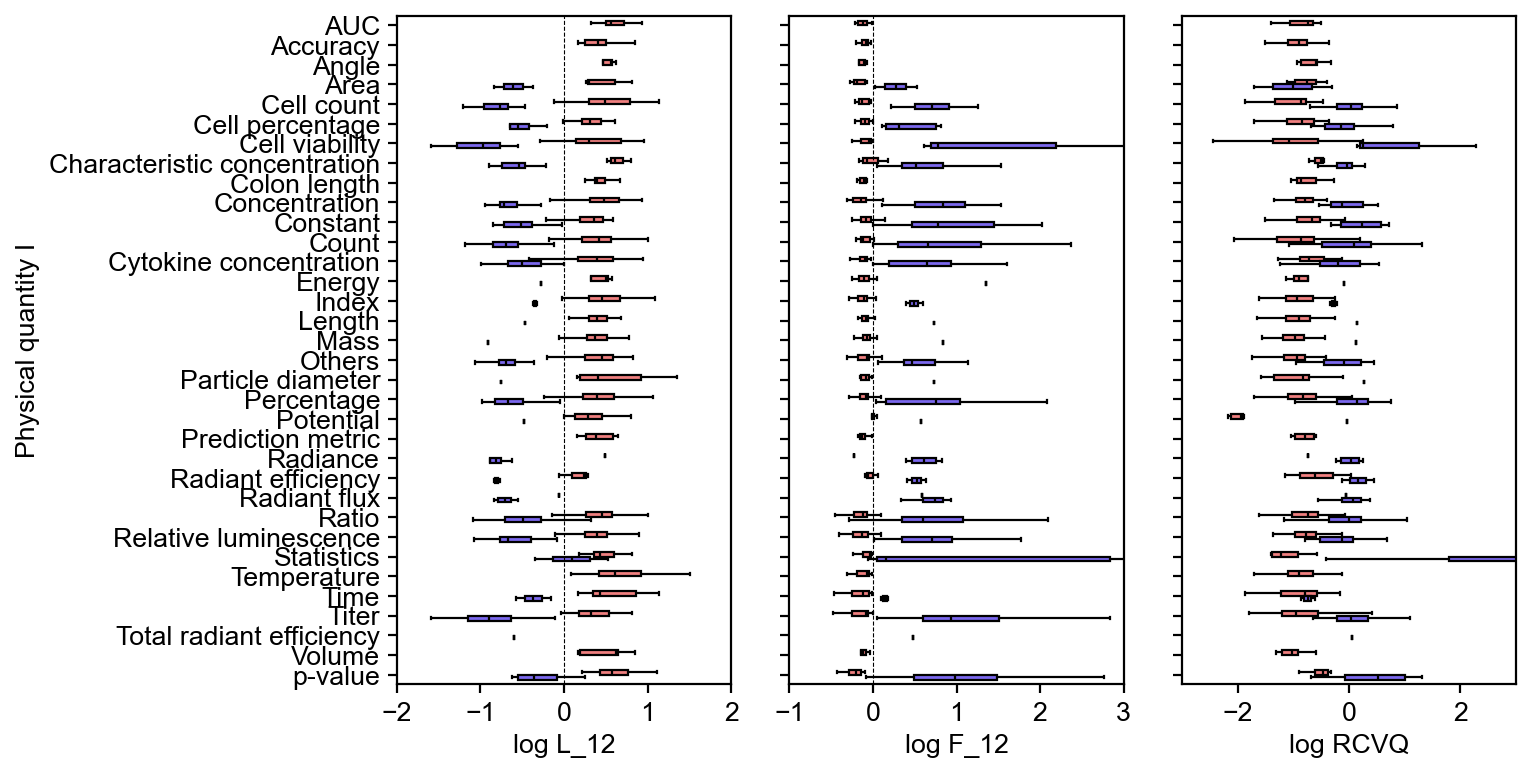

In [15]:
row = 1
col = 3
scale = 3
fig, axs = plt.subplots(row, col, figsize=(10, 5), sharey=True)

## subplot 1
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median().reset_index()
print(plot_df.shape)
sns.boxplot(
    plot_df,
    x='log L_12',
    y='Physical quantity I',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    legend=False,
    showfliers=False,
    order=np.unique(plot_df['Physical quantity I']),
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)

## subplot 2
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median().reset_index()
print(plot_df.shape)
sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Physical quantity I',
    hue='Mistake', 
    ax=axs[1],
    width=0.5,
    legend=False,
    showfliers=False,
    order=np.unique(plot_df['Physical quantity I']),
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)

## subplot 3
plot_df = util.keep_finite(cv_df)
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Physical quantity I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
plot_df = plot_df.reset_index()
print(plot_df.shape)
sns.boxplot(
    plot_df,
    x='log RCVQ', 
    y='Physical quantity I',
    hue='Mistake', 
    ax=axs[2],
    width=0.5,
    legend=False,
    showfliers=False,
    order=np.unique(plot_df['Physical quantity I']),
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)

for i in range(2):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
for i in range(col):
    axs[i].set_box_aspect(2)
    
axs[0].set_xlim(-2, 2)
axs[1].set_xlim(-1, 3)
axs[2].set_xlim(-3, 3)
plt.tight_layout()

#### Journal

In [16]:
# order by the 5th subplot
# in ascending fraction of zeroing (descending fraction of log)
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Journal', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Journal').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
order = df.sort_values('zero', ascending=True).index

(1151, 19)
(1151, 19)
(1121, 11)


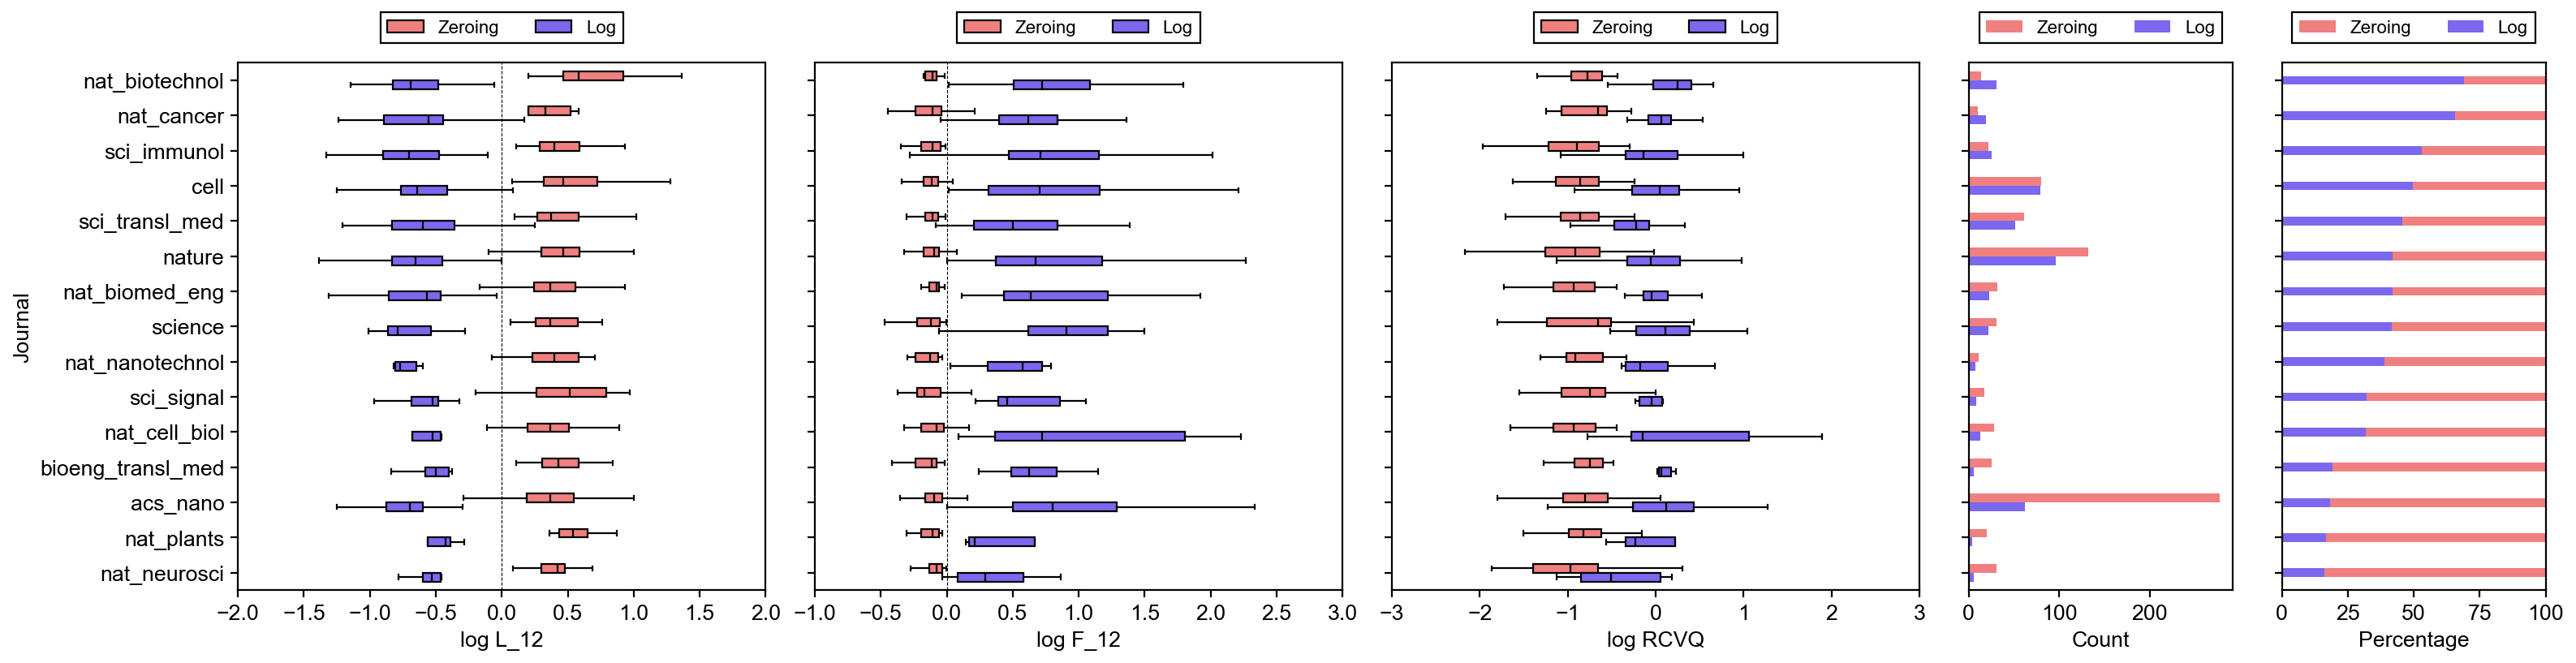

In [17]:
row = 1
col = 5
scale = 3
fig, axs = plt.subplots(row, col, figsize=(20, 5), sharey=True, width_ratios=[1, 1, 1, 0.5, 0.5])

## subplot 1
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Journal',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    order=order,
)
axs[0].set_xlim(-2.5, 2.5)

# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 2
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Journal',
    hue='Mistake', 
    ax=axs[1],
    width=0.5,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    order=order,
)
axs[1].set_xlim(-1, 3)

# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 3
plot_df = util.keep_finite(cv_df)
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Physical quantity I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity I']).median()
plot_df = plot_df.reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log RCVQ', 
    y='Journal',
    hue='Mistake', 
    ax=axs[2],
    width=0.5,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    order=order,
)
axs[1].set_xlim(-1, 3)

# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 4
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Journal', 'Mistake']).count().iloc[:, 0]
df.name = 'Count'
df = df.to_frame().reset_index()
plot_df = df.copy()

bar = sns.barplot(
    data=plot_df,
    x='Count',
    y='Journal',
    hue='Mistake',
    orient='h',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    width=0.5,
    ax=axs[3],
)
# configure legend
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 5
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Journal', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Journal').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
df = df.cumsum(axis=1).stack().reset_index(name='Percentage')
plot_df = df.copy()

bar = sns.barplot(
    plot_df,
    x='Percentage',
    y='Journal',
    hue='Mistake',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    dodge=False,
    saturation=1,
    width=0.25,
    ax=axs[4],
)
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

for i in range(2):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
for i in range(0, 3):
    axs[i].set_box_aspect(1)
for i in range(3, 5):
    axs[i].set_box_aspect(2)
    
axs[0].set_xlim(-2, 2)
axs[1].set_xlim(-1, 3)
axs[2].set_xlim(-3, 3)
axs[4].set_xlim(0, 100)
plt.tight_layout()

## Quantity annotation categories

Text(0.5, 0, 'Count')

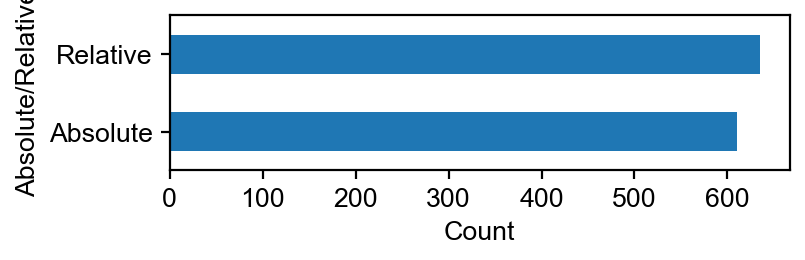

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Absolute/Relative', 'Physical quantity I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Absolute/Relative']).count().iloc[:, 0].sort_values().to_frame()
df.plot(
    kind='barh',
    legend=False,
    ax=ax,
)
ax.set_box_aspect(1/4)
ax.set_xlabel('Count')

Text(0.5, 0, 'Count')

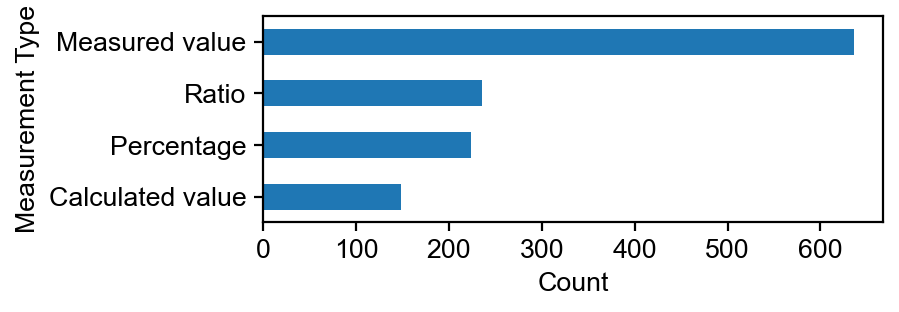

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurement Type', 'Physical quantity I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Measurement Type']).count().iloc[:, 0].sort_values().to_frame()
df.plot(
    kind='barh',
    legend=False,
    ax=ax,
)
ax.set_box_aspect(1/3)
ax.set_xlabel('Count')

Index(['Temperature', 'Mass', 'Time', 'Statistics', 'Bioluminescence',
       'Prediction metric', 'Constant', 'Length', 'Fluorescence', 'Others',
       'Count', 'Concentration', 'Percentage', 'Ratio'],
      dtype='object', name='Physical quantity II')

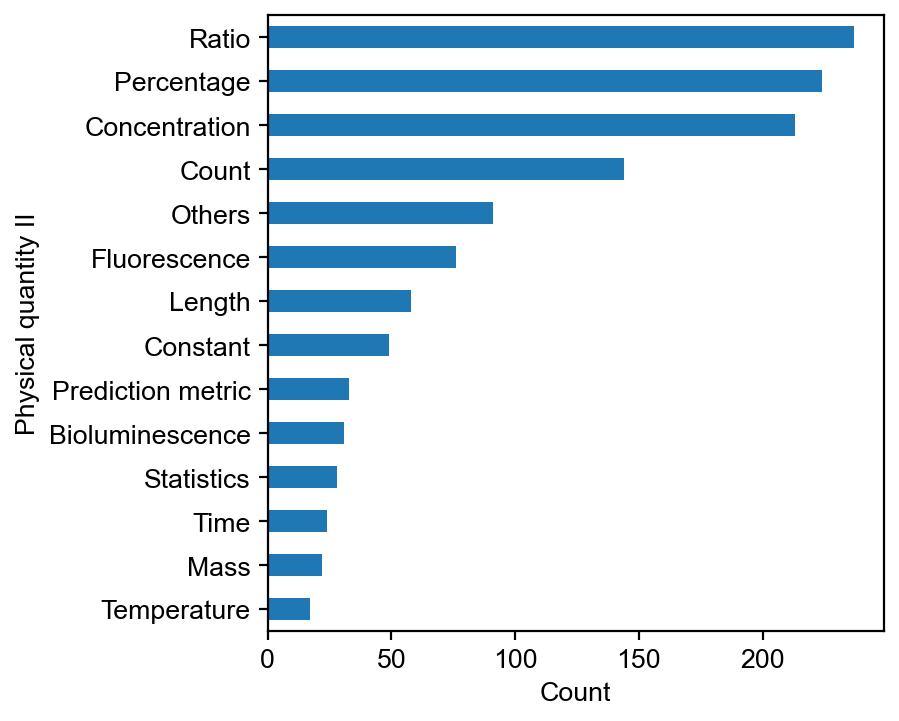

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity II', 'Physical quantity I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Physical quantity II']).count().iloc[:, 0].sort_values().to_frame()
df.plot(
    kind='barh',
    legend=False,
    ax=ax,
)
ax.set_box_aspect(1)
ax.set_xlabel('Count')
df.index

Index(['Total radiant efficiency', 'Angle', 'Radiant efficiency', 'Radiance',
       'Energy', 'Volume', 'Radiant flux', 'Area', 'Colon length',
       'Prediction metric', 'Potential', 'Accuracy', 'Statistics', 'AUC',
       'Particle diameter', 'Temperature', 'p-value', 'Cell viability', 'Mass',
       'Time', 'Constant', 'Index', 'Characteristic concentration',
       'Cytokine concentration', 'Length', 'Cell count', 'Cell percentage',
       'Others', 'Concentration', 'Titer', 'Relative luminescence', 'Count',
       'Percentage', 'Ratio'],
      dtype='object', name='Physical quantity I')

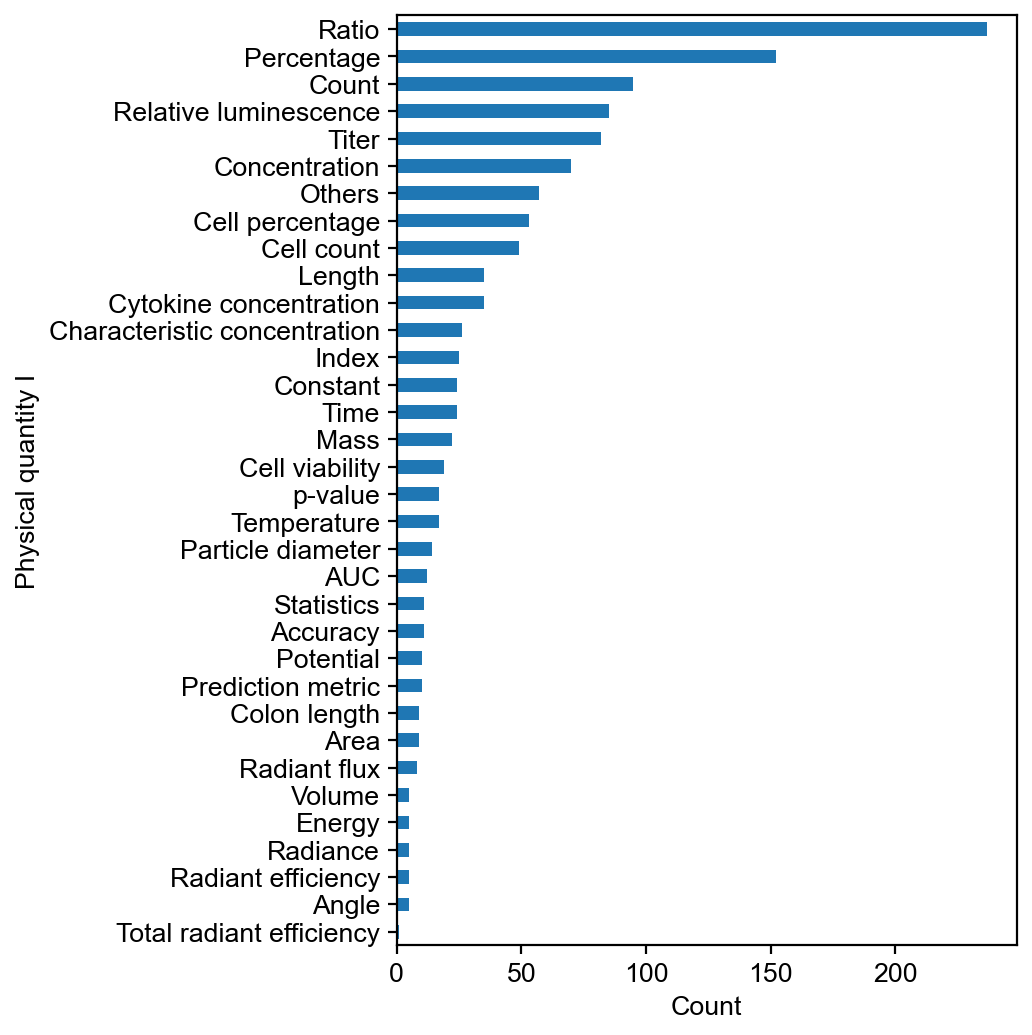

In [21]:
fig, ax = plt.subplots(figsize=(5, 10))
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Physical quantity I']).count().iloc[:, 0].sort_values().to_frame()
df.plot(
    kind='barh',
    legend=False,
    ax=ax,
)
ax.set_box_aspect(1.5)
ax.set_xlabel('Count')
df.index

### Sankey relation diagram for quantity annotations

In [204]:
base = 0
label_dict_1 = tuple(zip(bar_annot_df['Absolute/Relative'].unique(), np.arange(base, base + len(bar_annot_df['Absolute/Relative'].unique())+1)))
label_dict_1

(('Relative', 0), ('Absolute', 1))

In [205]:
base = 2
label_dict_2 = tuple(zip(bar_annot_df['Measurement Type'].unique(), np.arange(base, base + len(bar_annot_df['Measurement Type'].unique())+1)))
label_dict_2

(('Measured value', 2),
 ('Percentage', 3),
 ('Calculated value', 4),
 ('Ratio', 5))

In [206]:
base = 6
label_dict_3 = tuple(zip(bar_annot_df['Physical quantity II'].unique(), np.arange(base, base + len(bar_annot_df['Physical quantity II'].unique())+1)))
# label_dict_3

In [207]:
base = 20
label_dict_4 = tuple(zip(bar_annot_df['Physical quantity I'].unique(), np.arange(base, base + len(bar_annot_df['Physical quantity I'].unique())+1)))
# label_dict_4

In [208]:
label_dict = (label_dict_1 + label_dict_2 + label_dict_3 + label_dict_4)

In [209]:
sankey_data_list = []

In [210]:
df = bar_annot_df.groupby(['Absolute/Relative', 'Measurement Type']).count().iloc[:, 0].reset_index()
for label, index in label_dict_1:
    df.loc[df['Absolute/Relative'] == label, 'Absolute/Relative'] = index
for label, index in label_dict_2:
    df.loc[df['Measurement Type'] == label, 'Measurement Type'] = index
sankey_data_list.append(df.values.T)

In [211]:
df = bar_annot_df.groupby(['Measurement Type', 'Physical quantity II']).count().iloc[:, 0].reset_index()
for label, index in label_dict_2:
    df.loc[df['Measurement Type'] == label, 'Measurement Type'] = index
for label, index in label_dict_3:
    df.loc[df['Physical quantity II'] == label, 'Physical quantity II'] = index
sankey_data_list.append(df.values.T)

In [212]:
df = bar_annot_df.groupby(['Physical quantity II', 'Physical quantity I']).count().iloc[:, 0].reset_index()
for label, index in label_dict_3:
    df.loc[df['Physical quantity II'] == label, 'Physical quantity II'] = index
for label, index in label_dict_4:
    df.loc[df['Physical quantity I'] == label, 'Physical quantity I'] = index
sankey_data_list.append(df.values.T)

In [213]:
sankey_data = np.hstack(sankey_data_list)
sankey_data

array([[1, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 5, 5, 5, 19, 19, 19, 19, 10, 10, 10, 10, 15, 15, 17, 17,
        8, 8, 8, 8, 9, 9, 9, 13, 11, 11, 11, 11, 11, 11, 7, 7, 7, 18, 18,
        18, 12, 14, 14, 6, 16],
       [2, 4, 2, 3, 5, 19, 10, 15, 8, 11, 18, 12, 19, 10, 15, 17, 8, 9,
        13, 11, 18, 14, 6, 16, 7, 19, 8, 12, 39, 38, 50, 22, 51, 24, 26,
        25, 36, 40, 43, 44, 39, 38, 22, 52, 41, 23, 35, 29, 49, 27, 45,
        32, 37, 46, 30, 31, 21, 48, 47, 53, 28, 34, 33, 20, 42],
       [1743, 489, 59, 519, 756, 58, 1, 43, 149, 7, 217, 14, 28, 767, 50,
        475, 16, 102, 54, 156, 1, 49, 45, 59, 519, 4, 7, 745, 5, 2, 21,
        62, 84, 131, 111, 442, 50, 43, 201, 274, 3, 8, 157, 4, 31, 54,
        17, 54, 11, 17, 10, 90, 14, 21, 126, 35, 358, 108, 59, 51, 759,
        13, 36, 45, 59]], dtype=object)

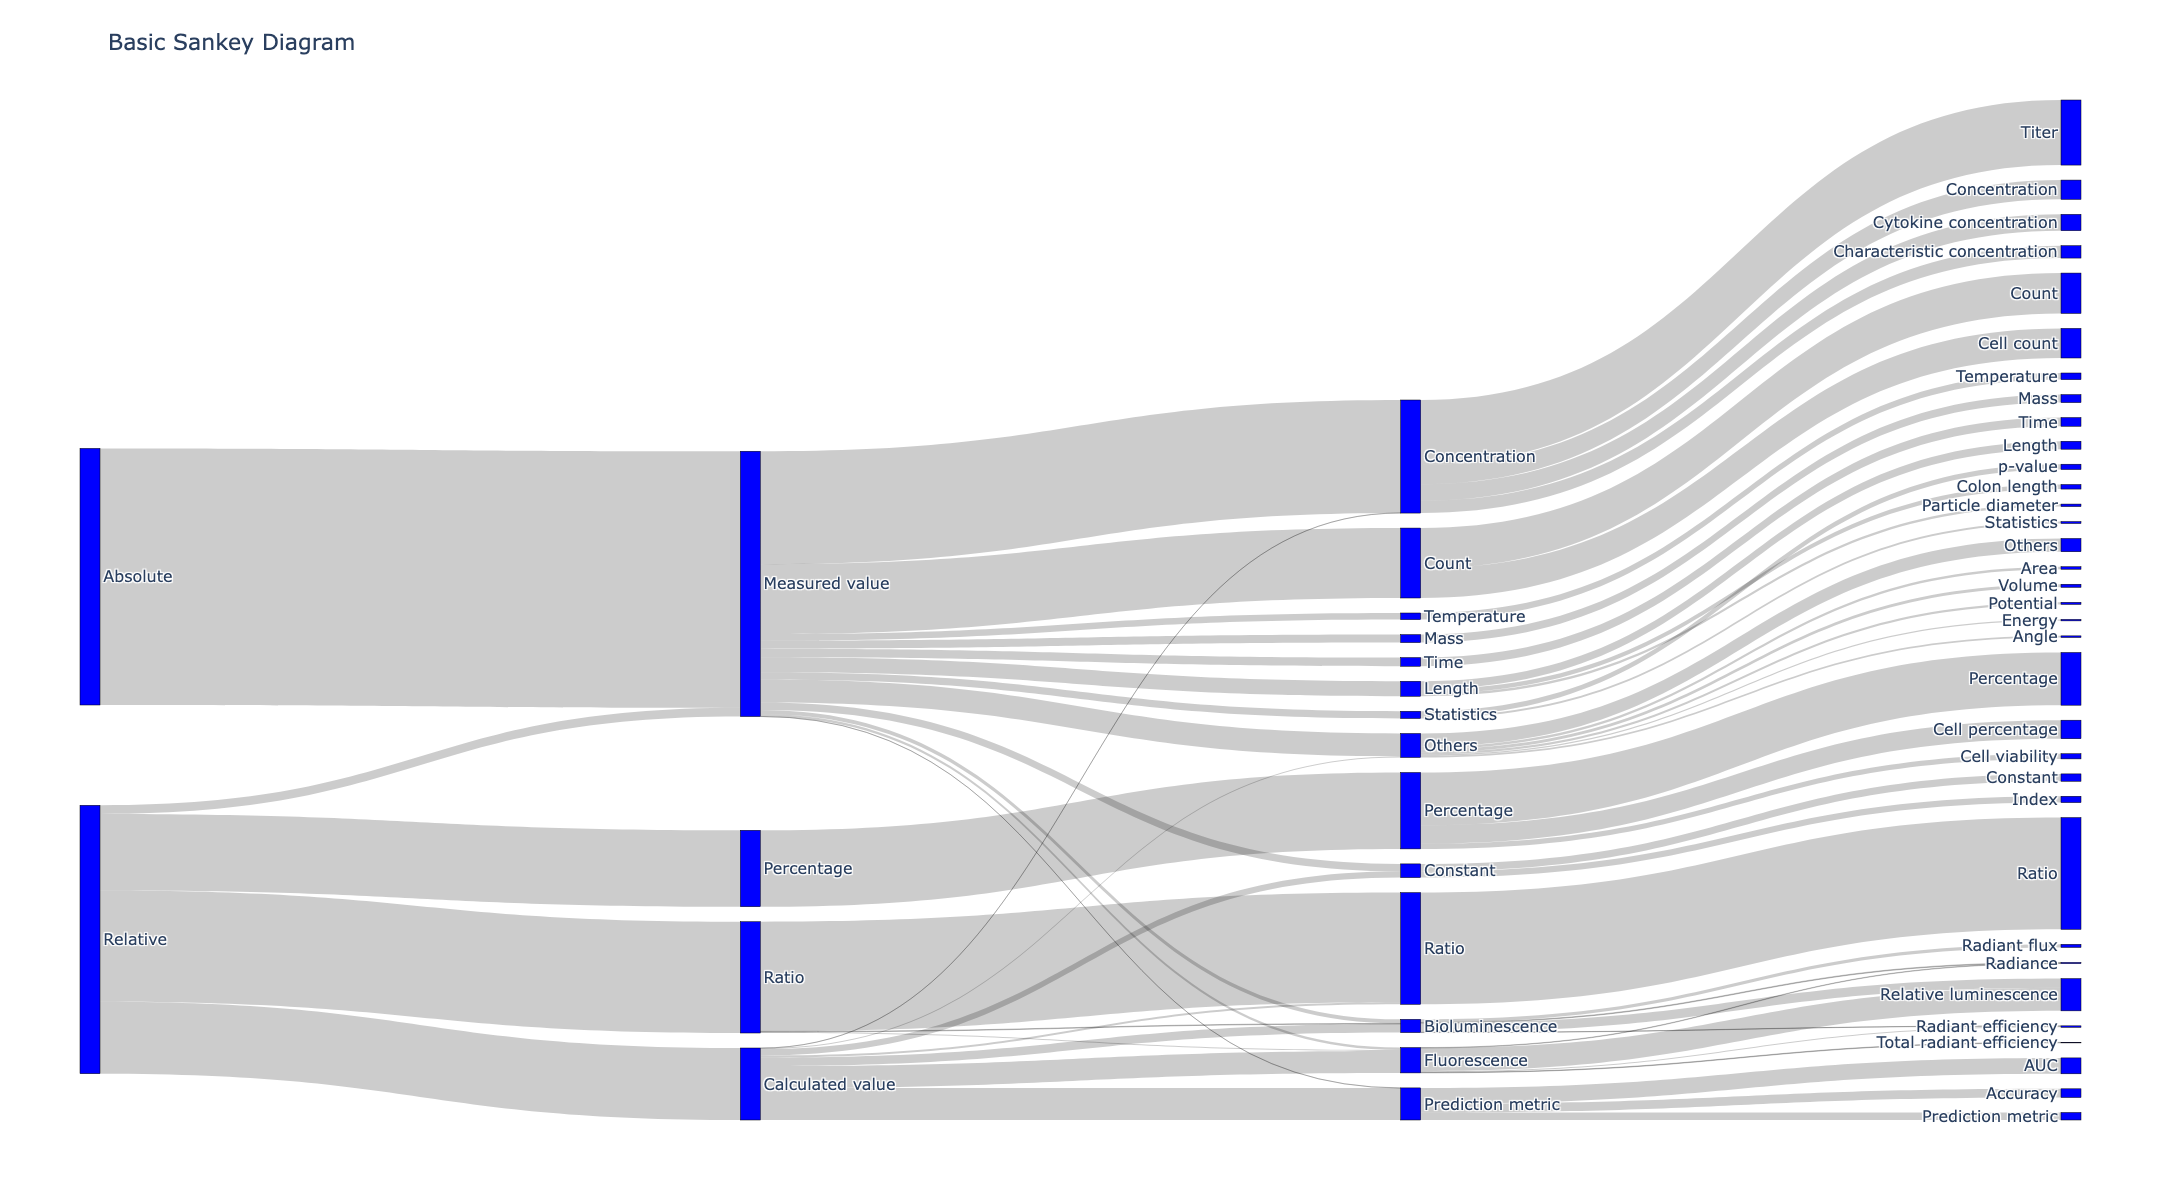

In [214]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = np.array(label_dict)[:, 0],
        color = "blue"
    ),
    link = dict(
        source = sankey_data[0], # indices correspond to labels, eg A1, A2, A1, B1, ...
        target = sankey_data[1],
        value = sankey_data[2],
    )
)],)

fig.update_layout(title_text="Basic Sankey Diagram", font_size=16, width=1500, height=1200)
fig.show()

## Pairing rel and abs deviations

In [297]:
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
plot_df

,Absolute/Relative,Journal,DOI,Mistake,Physical quantity II,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12
0,Absolute,acs_nano,10.1021:acsnano.2c07436,log,Others,0.000273,0.000225,0.812121,0.783838,3.0,1.00,1.990668,0.202061,0.101507,-0.993505,-89.849276,2.487931,0.395831,-0.898493
1,Absolute,acs_nano,10.1021:acsnano.2c08153,log,Concentration,12.254337,1.057942,0.892528,0.467438,4.5,4.25,7.610832,1.114541,0.084832,-1.112391,-91.516824,5.352501,0.691635,-0.915168
2,Absolute,acs_nano,10.1021:acsnano.2c08153,zero,Length,6.701940,0.176367,0.680887,0.049488,4.0,5.00,28.230769,11.468750,0.344828,-0.462398,-65.517241,2.344322,0.370017,-0.655172
3,Absolute,acs_nano,10.1021:acsnano.2c08240,zero,Concentration,126.888046,125.834915,0.459203,0.388994,3.0,1.00,0.011583,0.274011,21.565854,1.333767,2056.585366,0.797643,-0.099242,20.565854
4,Absolute,acs_nano,10.1021:acsnano.2c08434,log,Length,421.147657,8.464510,0.874811,0.309201,5.0,4.00,7.376776,0.614555,0.074540,-1.127610,-92.545996,5.404842,0.732783,-0.925460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,Relative,science,10.1126:science.adi2246,log,Ratio,1.368317,0.003413,0.856031,0.422179,5.0,10.50,39.881060,0.649846,0.015225,-1.817540,-98.477522,23.169582,1.364811,-0.984775
1108,Relative,science,10.1126:science.adi4720,zero,Temperature,72.022998,68.937198,0.801533,0.386712,2.5,1.00,0.033757,0.776572,17.524751,1.243470,1652.475136,0.601741,-0.220716,16.524751
1109,Relative,science,10.1126:science.adi8885,log,Ratio,1.213554,0.741725,0.083935,-0.234274,0.0,1.00,1.608392,-0.471876,2.514590,0.731242,151.458985,-15.140926,-0.060626,1.514590
1110,Relative,science,10.1126:science.adi8885,zero,Percentage,76.182553,52.688033,0.769709,0.378134,1.0,0.00,0.418345,1.991251,3.196228,0.439864,219.622776,0.679365,-0.219349,2.196228


Text(0, 0.5, 'log $F_{1/2}$')

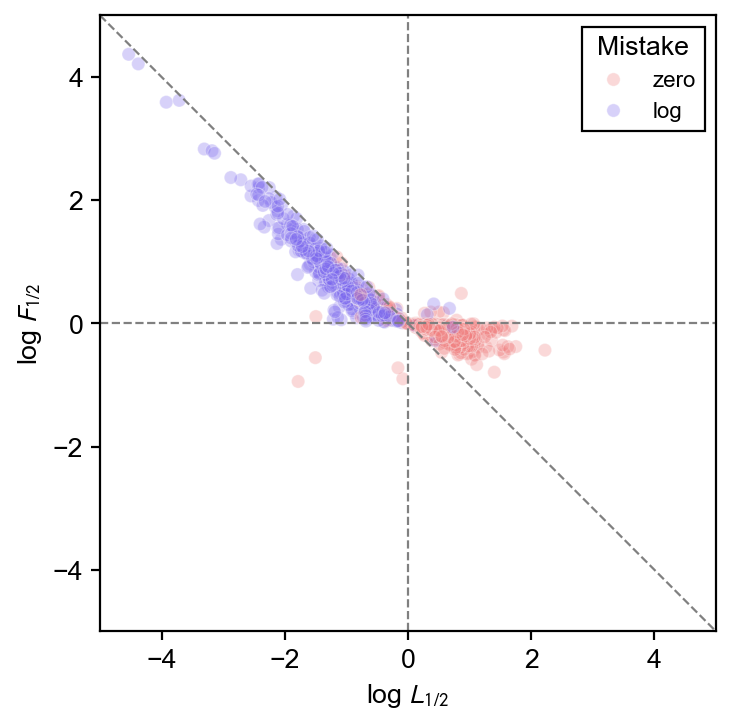

In [326]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    plot_df,
    x='log L_12',
    y='log F_12',
    hue='Mistake',
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    alpha=0.3,
    # s=10,
    ax=ax,
)
ax.plot([-5, 5], [5, -5], '--', color='gray')
ax.plot([-5, 5], [0, 0], '--', color='gray')
ax.plot([0, 0], [-5, 5], '--', color='gray')
ax.set_box_aspect(1)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel('log $L_{1/2}$')
ax.set_ylabel('log $F_{1/2}$')

In [322]:
plot_df[plot_df['Mistake'] == 'zero'].shape

(722, 19)

In [323]:
plot_df[plot_df['Mistake'] == 'log'].shape

(390, 19)

<!-- ## Number and frequencies -->

In [28]:
bar_annot_df[bar_annot_df['Physical quantity II'] == 'Concentration'].groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index().groupby(['Physical quantity I']).count()

,DOI,Mistake,Fig ID
Physical quantity I,,,
Characteristic concentration,26,26,26
Concentration,70,70,70
Cytokine concentration,35,35,35
Titer,82,82,82


In [29]:
for quant_idx in bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count().index:
    print(bar_annot_df[bar_annot_df['Physical quantity II'] == quant_idx].groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index().groupby(['Physical quantity I']).count())

                       DOI  Mistake  Fig ID
Physical quantity I                        
Radiance                 3        3       3
Radiant efficiency       2        2       2
Radiant flux             8        8       8
Relative luminescence   18       18      18
                              DOI  Mistake  Fig ID
Physical quantity I                               
Characteristic concentration   26       26      26
Concentration                  70       70      70
Cytokine concentration         35       35      35
Titer                          82       82      82
                     DOI  Mistake  Fig ID
Physical quantity I                      
Constant              24       24      24
Index                 25       25      25
                     DOI  Mistake  Fig ID
Physical quantity I                      
Cell count            49       49      49
Count                 95       95      95
                          DOI  Mistake  Fig ID
Physical quantity I                           


In [30]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index()

,DOI,Mistake,Physical quantity I,Fig ID
0,10.1002:btm2.10487,log,Constant,2
1,10.1002:btm2.10499,zero,Concentration,1
2,10.1002:btm2.10499,zero,Cytokine concentration,5
3,10.1002:btm2.10504,zero,Titer,1
4,10.1002:btm2.10505,zero,Titer,2
...,...,...,...,...
1239,10.1126:scitranslmed.adh4529,log,Count,1
1240,10.1126:scitranslmed.adh7668,zero,Count,1
1241,10.1126:scitranslmed.adi1617,log,Radiance,1
1242,10.1126:scitranslmed.adi7244,zero,Cell percentage,3


In [31]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index().groupby(['Physical quantity I']).count()

,DOI,Mistake,Fig ID
Physical quantity I,,,
AUC,12,12,12
Accuracy,11,11,11
Angle,5,5,5
Area,9,9,9
Cell count,49,49,49
Cell percentage,53,53,53
Cell viability,19,19,19
Characteristic concentration,26,26,26
Colon length,9,9,9


In [32]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0]

DOI                           Mistake  Absolute/Relative
10.1002:btm2.10487            log      Absolute             2
10.1002:btm2.10499            zero     Absolute             6
10.1002:btm2.10504            zero     Absolute             1
10.1002:btm2.10505            zero     Absolute             2
10.1002:btm2.10514            log      Absolute             2
                                                           ..
10.1126:scitranslmed.adh4529  log      Relative             2
10.1126:scitranslmed.adh7668  zero     Absolute             1
10.1126:scitranslmed.adi1617  log      Absolute             1
10.1126:scitranslmed.adi7244  zero     Relative             3
10.1126:scitranslmed.adi9867  log      Absolute             2
Name: Fig ID, Length: 1036, dtype: int64

In [33]:
plot_df

,Journal,Mistake,Percentage
0,acs_nano,log,18.235294
1,acs_nano,zero,100.000000
2,bioeng_transl_med,log,19.354839
3,bioeng_transl_med,zero,100.000000
4,cell,log,49.685535
5,cell,zero,100.000000
6,nat_biomed_eng,log,41.818182
7,nat_biomed_eng,zero,100.000000
8,nat_biotechnol,log,68.888889
9,nat_biotechnol,zero,100.000000


In [34]:
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0)
df = df.cumsum(axis=1).stack().reset_index(name='Cumsum')
plot_df = df.copy()
plot_df

,Absolute/Relative,Mistake,Cumsum
0,Absolute,log,0.478261
1,Absolute,zero,1.000000
2,Relative,log,0.307547
3,Relative,zero,1.000000


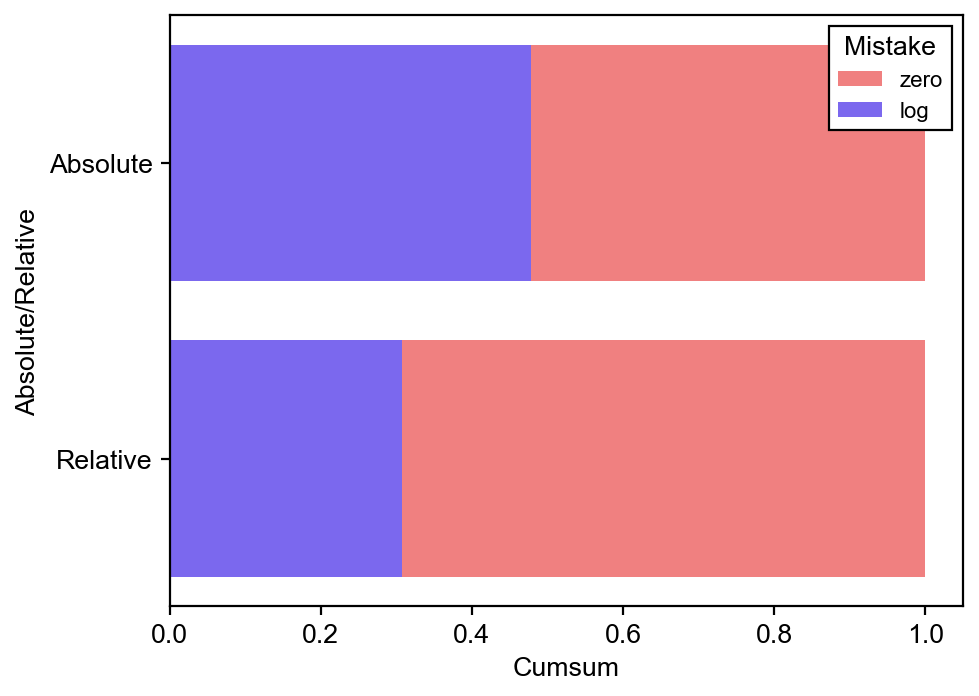

In [35]:
bar = sns.barplot(
    plot_df,
    x='Cumsum',
    y='Absolute/Relative',
    hue='Mistake',
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    dodge=False,
    saturation=1,
)

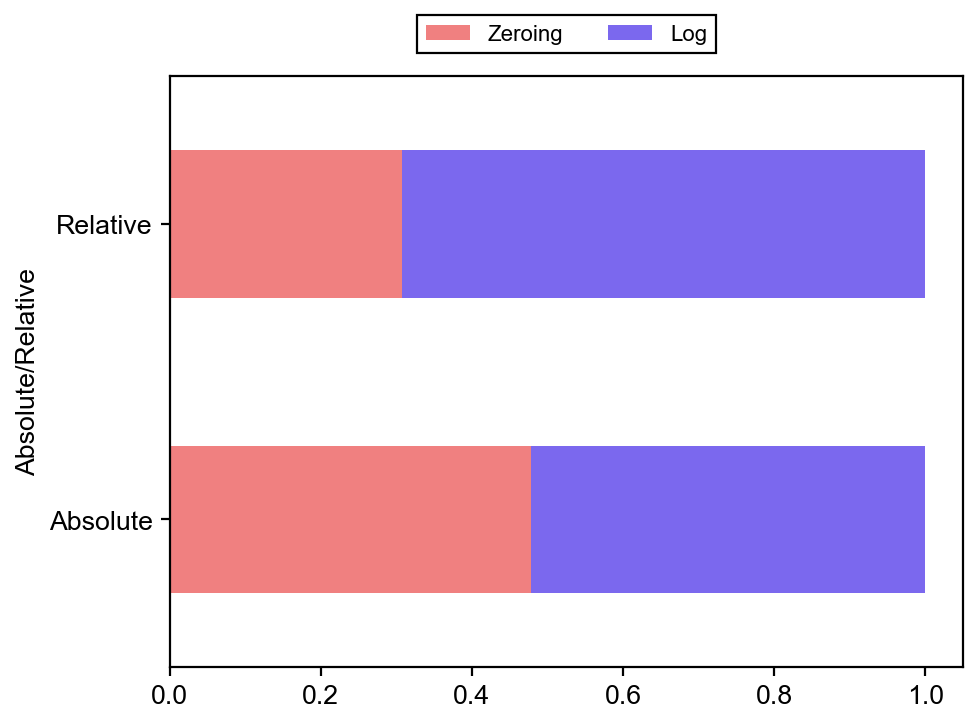

In [36]:
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0)
plot_df = df.copy()
bar = plot_df.plot(
    kind='barh', 
    stacked=True, 
    legend=True,
    color=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR], 
    # ax=ax,
)
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

In [37]:
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0)
df.iloc[:, [0, 1]] = df.iloc[:, [1, 0]]
df.columns = df.columns[::-1]
plot_df = df.copy()
plot_df

Mistake,zero,log
Absolute/Relative,,
Absolute,0.521739,0.478261
Relative,0.692453,0.307547


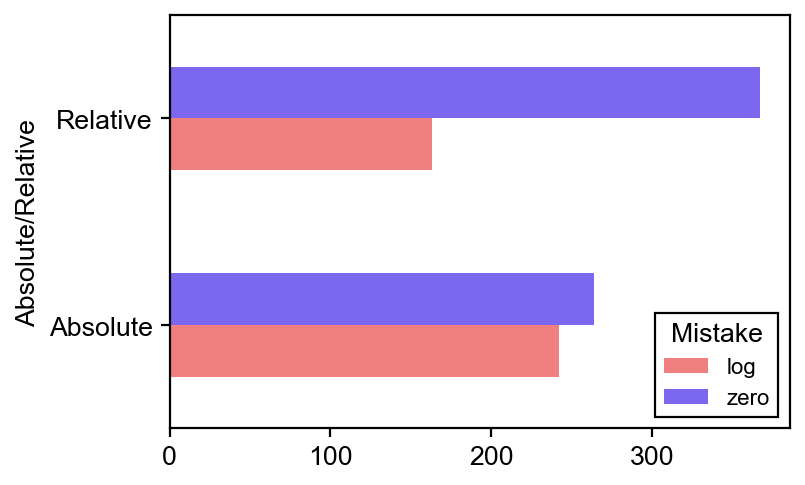

In [38]:
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
plot_df = df.copy()

fig, ax = plt.subplots(figsize=(5, 5))
plot_df.plot(
    kind='barh', 
    stacked=False, 
    legend=True,
    color=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR], 
    ax=ax,
)
ax.set_box_aspect(2/3)

,Absolute/Relative,Mistake,Count
0,Absolute,log,242
1,Absolute,zero,264
2,Relative,log,163
3,Relative,zero,367


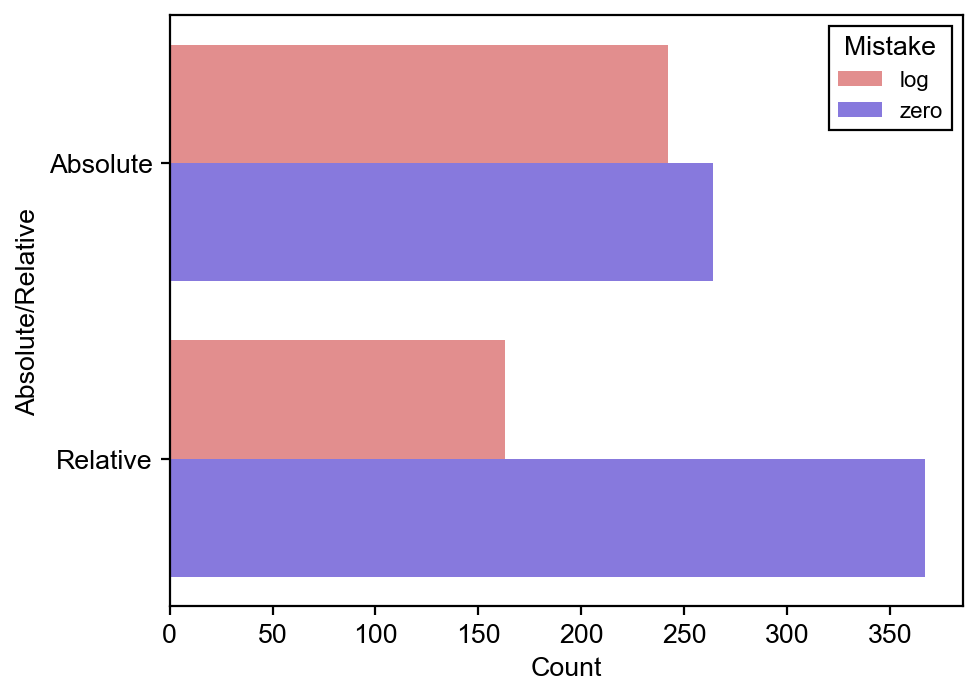

In [39]:
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0]
df.name = 'Count'
df = df.to_frame().reset_index()
plot_df = df.copy()

sns.barplot(
    data=plot_df,
    x='Count',
    y='Absolute/Relative',
    hue='Mistake',
    orient='h',
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
plot_df

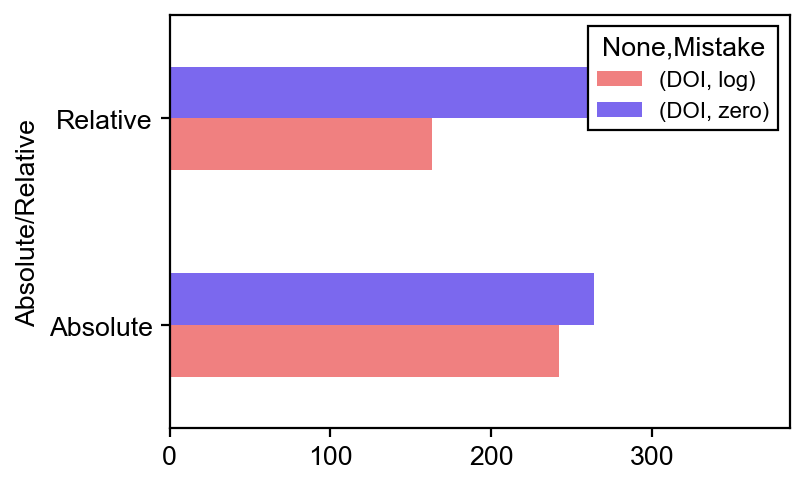

In [40]:
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index().groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index().set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
df = df.sort_values(('DOI', 'zero'))
fig, ax = plt.subplots(figsize=(5, 5))
df.plot(
    kind='barh', 
    stacked=False, 
    legend=True,
    color=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR], 
    ax=ax
)
ax.set_box_aspect(2/3)

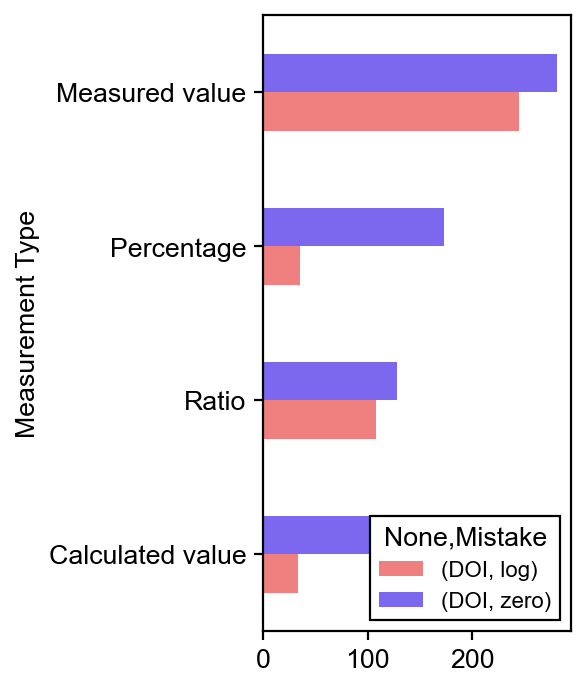

In [41]:
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Measurement Type']).count().iloc[:, 0].reset_index().groupby(['Measurement Type', 'Mistake']).count().iloc[:, 0].to_frame().reset_index().set_index('Measurement Type').pivot(columns='Mistake').fillna(0)
df = df.sort_values(('DOI', 'zero'))
fig, ax = plt.subplots(figsize=(5, 5))
df.plot(
    kind='barh', 
    stacked=False, 
    legend=True,
    color=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR], 
    ax=ax,
)
ax.set_box_aspect(2)

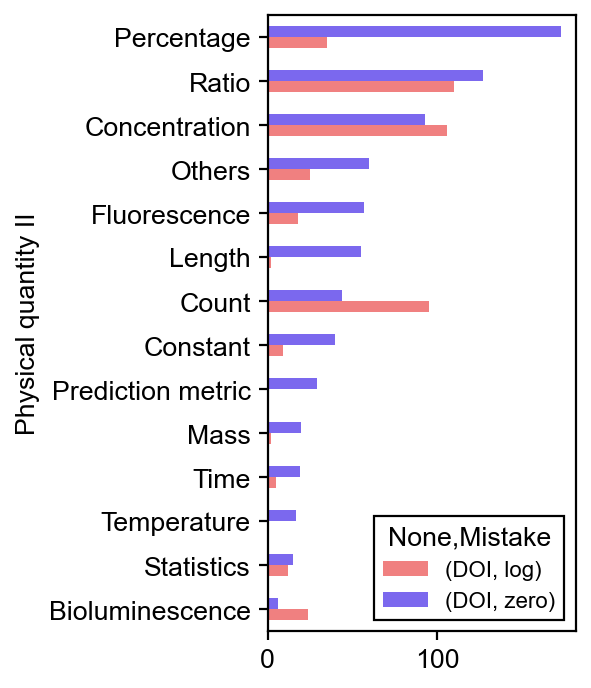

In [42]:
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II', 'Mistake']).count().iloc[:, 0].to_frame().reset_index().set_index('Physical quantity II').pivot(columns='Mistake').fillna(0)
df = df.sort_values(('DOI', 'zero'))
fig, ax = plt.subplots(figsize=(5, 5))
df.plot(
    kind='barh',
    stacked=False,
    legend=True,
    color=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR], 
    ax=ax
)
ax.set_box_aspect(2)

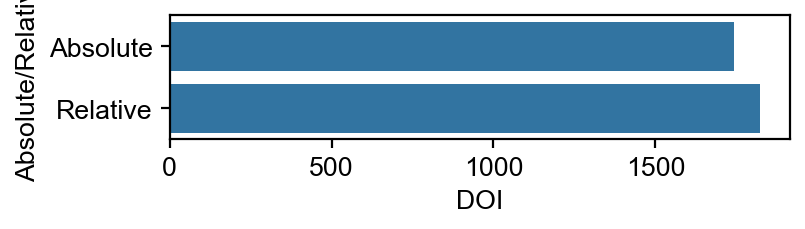

In [43]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    data=bar_annot_df.groupby('Absolute/Relative').count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby('Absolute/Relative').count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(0.2)

In [44]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count().sum()

DOI        1198
Mistake    1198
Fig ID     1198
dtype: int64

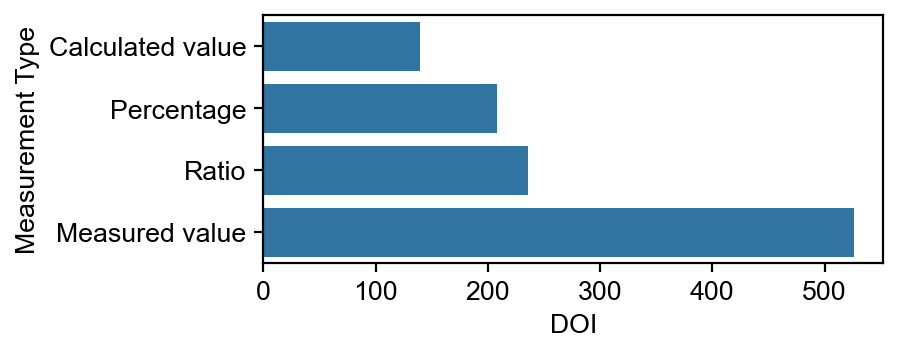

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    data=bar_annot_df.groupby(['DOI', 'Mistake', 'Measurement Type']).count().iloc[:, 0].reset_index().groupby(['Measurement Type']).count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby(['DOI', 'Mistake', 'Measurement Type']).count().iloc[:, 0].reset_index().groupby(['Measurement Type']).count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(0.4)

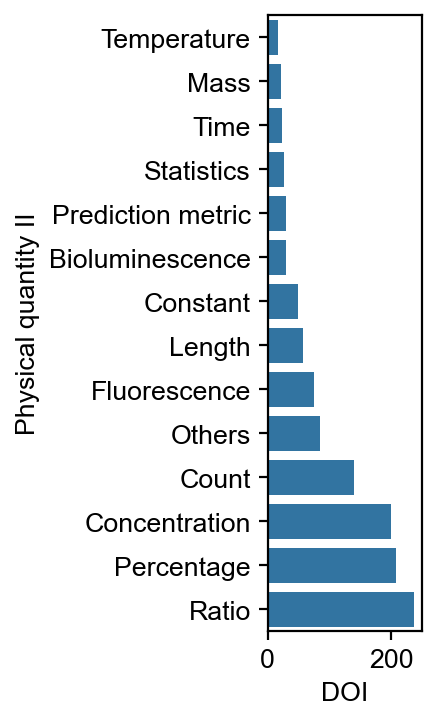

In [46]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    data=bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(4)

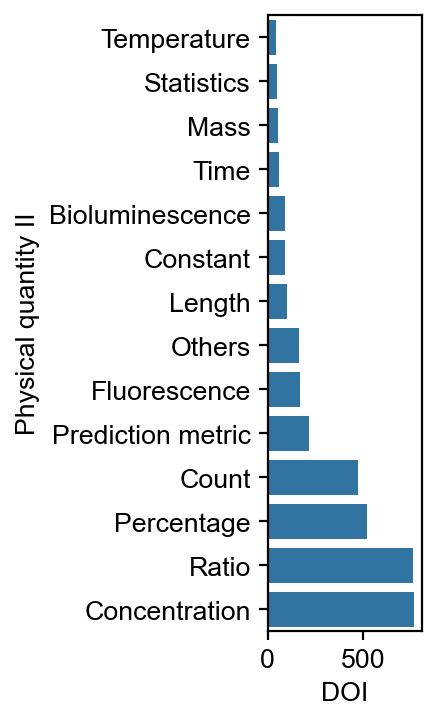

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    data=bar_annot_df.groupby('Physical quantity II').count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby('Physical quantity II').count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(4)

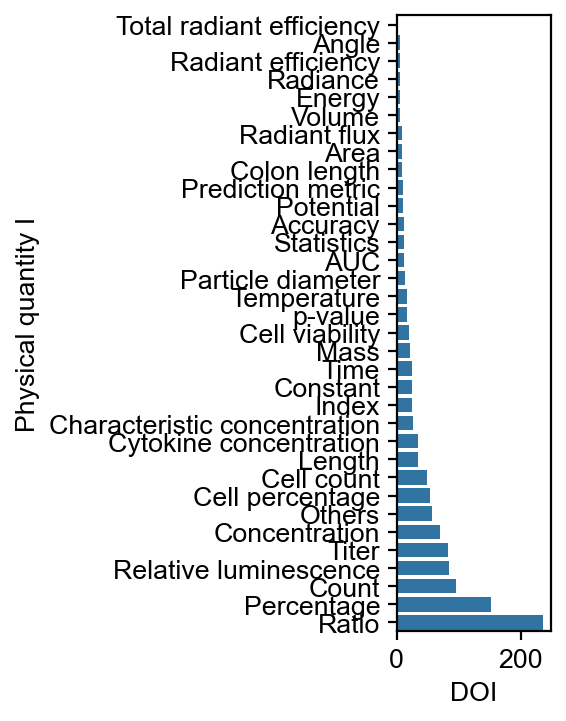

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    data=bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index().groupby(['Physical quantity I']).count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity I']).count().iloc[:, 0].reset_index().groupby(['Physical quantity I']).count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(4)

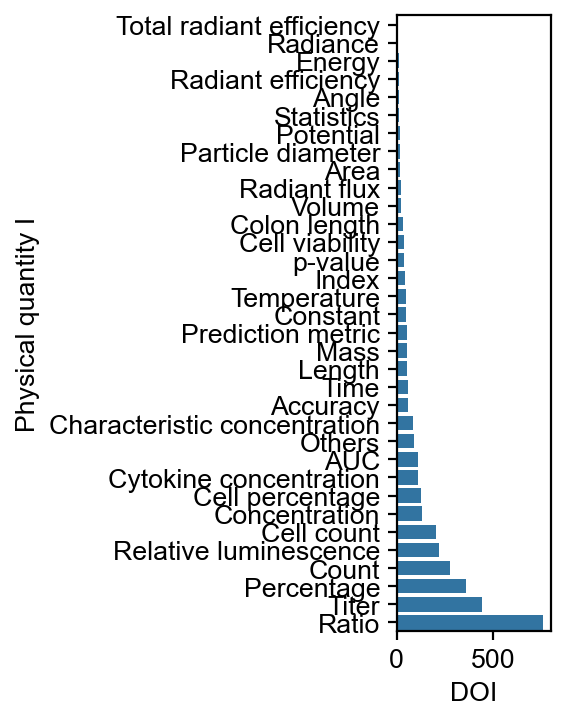

In [49]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    data=bar_annot_df.groupby('Physical quantity I').count().iloc[:, 0],
    orient='h',
    order=bar_annot_df.groupby('Physical quantity I').count().iloc[:, 0].sort_values().index,
    ax=ax
)
ax.set_box_aspect(4)

In [50]:
bar_annot_df[bar_annot_df['Physical quantity II'].isin(['Length'])].groupby('Physical quantity I').count()

,DOI,Mistake,Fig ID,Journal,Quantity,Absolute/Relative,Measurement Type,Physical quantity II,Log transformation
Physical quantity I,,,,,,,,,
Colon length,31,31,31,31,31,31,31,31,31
Length,54,54,54,54,54,54,54,54,54
Particle diameter,17,17,17,17,17,17,17,17,17


In [51]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Physical quantity II']).count()

,DOI,Mistake,Fig ID
Physical quantity II,,,
Bioluminescence,30,30,30
Concentration,199,199,199
Constant,49,49,49
Count,139,139,139
Fluorescence,75,75,75
Length,57,57,57
Mass,22,22,22
Others,85,85,85
Percentage,208,208,208


In [52]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index().groupby(['Absolute/Relative']).count()

,DOI,Mistake,Fig ID
Absolute/Relative,,,
Absolute,506,506,506
Relative,530,530,530


## Bar-level data

## Pairwise permutation-level metric

In [53]:
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Mistake']])
plot_df

,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12,Absolute/Relative,Mistake
Fig Index,,,,,,,,,,,,,,,,
10.1002:btm2.10487_log_fig1,2.459140,2.459140,0.462832,0.462832,1.5,1.5,0.741462,0.057445,0.417407,-0.382415,-58.259341,1.105150,0.000000e+00,-0.582593,Absolute,log
10.1002:btm2.10487_log_fig2,6.461362,6.461362,0.448692,0.448692,1.5,1.5,0.859204,0.077444,0.427339,-0.374663,-57.266116,1.099787,0.000000e+00,-0.572661,Absolute,log
10.1002:btm2.10499_zero_fig1,23.125241,23.125241,0.366089,0.366089,3.5,3.5,0.000306,0.003109,4.692459,0.664729,369.245939,1.001392,3.295975e-17,3.692459,Absolute,zero
10.1002:btm2.10499_zero_fig2,17.704626,17.704626,0.423488,0.423488,3.0,3.0,0.000014,0.000021,1.393557,0.144125,39.355742,1.000001,1.114018e-17,0.393557,Absolute,zero
10.1002:btm2.10499_zero_fig3,13.212996,13.212996,0.328520,0.328520,3.0,3.0,0.000007,0.000020,1.608791,0.206500,60.879121,1.000003,-2.016616e-17,0.608791,Absolute,zero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1126:scitranslmed.adi7244_zero_fig1,48.135048,48.135048,0.604502,0.604502,0.5,0.5,0.013930,0.102449,2.738993,0.433283,173.899336,1.040072,-6.938894e-18,1.738993,Relative,zero
10.1126:scitranslmed.adi7244_zero_fig2,88.396694,88.396694,0.439669,0.439669,0.5,0.5,0.001313,0.722065,27.002885,1.370101,2600.288534,1.652451,5.551115e-17,26.002885,Relative,zero
10.1126:scitranslmed.adi7244_zero_fig3,68.875639,68.875639,0.471891,0.471891,0.5,0.5,0.028594,0.462064,4.260902,0.604216,326.090183,1.246988,-5.551115e-17,3.260902,Relative,zero


In [54]:
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df)

plot_df.groupby(['Mistake', 'Physical quantity II']).count()

x_1  x_2  y_1  y_2  Bar 1 ID  Bar 2 ID  E_x_12  \
Mistake Physical quantity II                                                   
log     Bioluminescence        75   75   75   75        75        75      75   
        Concentration         447  447  447  447       447       447     447   
        Constant               17   17   17   17        17        17      17   
        Count                 252  252  252  252       252       252     252   
        Fluorescence           45   45   45   45        45        45      45   
        Length                  2    2    2    2         2         2       2   
        Mass                    3    3    3    3         3         3       3   
        Others                 40   40   40   40        40        40      40   
        Percentage             67   67   67   67        67        67      67   
        Ratio                 349  349  349  349       349       349     349   
        Statistics             26   26   26   26        26        26      26   
        Time                    3    3    3    3         3         3       3   
zero    Bioluminescence         8    8    8    8         8         8       8   
        Concentration         265  265  263  263       265       265     265   
        Constant               71   71   71   71        71        71      71   
        Count                 161  161  161  161       161       161     161   
        Fluorescence          125  125  125  125       125       125     125   
        Length                 95   95   95   95        95        95      95   
        Mass                   50   50   50   50        50        50      50   
        Others                112  112  112  112       112       112     112   
        Percentage            404  404  404  404       404       404     404   
        Prediction metric     206  206  206  206       206       206     206   
        Ratio                 325  325  325  325       325       325     325   
        Statistics             17   17   17   17        17        17      17   
        Temperature            45   45   45   45        45        45      45   
        Time                   50   50   50   50        50        50      50   

                              E_y_12  L_12  log L_12  ...  log F_12  RGD_12  \
Mistake Physical quantity II                          ...                     
log     Bioluminescence           75    75        74  ...        75      75   
        Concentration            447   447       444  ...       447     447   
        Constant                  17    17        16  ...        17      17   
        Count                    252   252       252  ...       252     252   
        Fluorescence              45    45        45  ...        45      45   
        Length                     2     2         2  ...         2       2   
        Mass                       3     3         3  ...         3       3   
        Others                    40    40        38  ...        40      40   
        Percentage                67    67        67  ...        67      67   
        Ratio                    349   349       334  ...       341     349   
        Statistics                26    26        10  ...        26      26   
        Time                       3     3         3  ...         3       3   
zero    Bioluminescence            8     8         8  ...         8       8   
        Concentration            263   263       262  ...       263     263   
        Constant                  71    71        63  ...        71      71   
        Count                    161   161       160  ...       161     161   
        Fluorescence             125   125       125  ...       125     125   
        Length                    95    95        95  ...        95      95   
        Mass                      50    50        50  ...        50      50   
        Others                   112   112       111  ...       112     112   
        Percentage               404   404       40

In [55]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(plot_df.groupby(['Mistake', 'Physical quantity I']).count()['x_1'])

Mistake  Physical quantity I         
log      Area                              4
         Cell count                      131
         Cell percentage                  16
         Cell viability                    3
         Characteristic concentration     70
         Concentration                    34
         Constant                         10
         Count                           121
         Cytokine concentration           51
         Energy                            1
         Index                             7
         Length                            1
         Mass                              3
         Others                           34
         Particle diameter                 1
         Percentage                       48
         Potential                         1
         Radiance                          6
         Radiant efficiency                2
         Radiant flux                     20
         Ratio                           349
         Relative

In [56]:
plot_df.groupby(['DOI', 'Mistake', 'Physical quantity II']).count().iloc[:, 0].reset_index().groupby(['Mistake', 'Physical quantity II']).count()

DOI  x_1
Mistake Physical quantity II          
log     Bioluminescence        21   21
        Concentration          99   99
        Constant                9    9
        Count                  72   72
        Fluorescence           18   18
        Length                  2    2
        Mass                    1    1
        Others                 24   24
        Percentage             30   30
        Ratio                  99   99
        Statistics             12   12
        Time                    2    2
zero    Bioluminescence         6    6
        Concentration          92   92
        Constant               39   39
        Count                  42   42
        Fluorescence           57   57
        Length                 53   53
        Mass                   20   20
        Others                 58   58
        Percentage            165  165
        Prediction metric      24   24
        Ratio                 118  118
        Statistics             11   11
        Temperature            17   17
        Time                   18   18

In [57]:
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
plot_df

,Journal,DOI,Mistake,Physical quantity II,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12
0,acs_nano,10.1021:acsnano.2c07293,zero,Temperature,40.690994,32.616460,0.827640,0.504658,0.0,2.00,0.144073,0.329177,2.585231,0.412499,158.523077,0.860738,-0.065129,1.585231
1,acs_nano,10.1021:acsnano.2c07436,log,Others,0.000273,0.000225,0.812121,0.783838,3.0,1.00,1.990668,0.202061,0.101507,-0.993505,-89.849276,2.487931,0.395831,-0.898493
2,acs_nano,10.1021:acsnano.2c07436,zero,Percentage,69.956332,67.161572,0.748908,0.679039,3.0,1.00,0.049762,0.122186,2.472669,0.393166,147.266881,0.935309,-0.029066,1.472669
3,acs_nano,10.1021:acsnano.2c07439,zero,Fluorescence,0.288557,0.043118,0.238938,0.129794,4.0,1.00,3.833333,0.741935,0.147727,-0.830539,-85.227273,2.705882,0.432309,-0.852273
4,acs_nano,10.1021:acsnano.2c08153,log,Concentration,12.254337,1.057942,0.892528,0.467438,4.5,4.25,7.610832,1.114541,0.084832,-1.112391,-91.516824,5.352501,0.691635,-0.915168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,science,10.1126:science.adi4720,zero,Temperature,72.022998,68.937198,0.801533,0.386712,2.5,1.00,0.033757,0.776572,17.524751,1.243470,1652.475136,0.601741,-0.220716,16.524751
1105,science,10.1126:science.adi8885,log,Ratio,1.213554,0.741725,0.083935,-0.234274,0.0,1.00,1.608392,-0.471876,2.514590,0.731242,151.458985,-15.140926,-0.060626,1.514590
1106,science,10.1126:science.adi8885,zero,Count,8.608350,6.798058,0.690909,0.495396,0.0,1.00,0.221012,0.346734,1.789877,0.252823,78.987730,0.889580,-0.050815,0.789877
1107,science,10.1126:science.adi8885,zero,Percentage,76.182553,52.688033,0.769709,0.378134,1.0,0.00,0.418345,1.991251,3.196228,0.439864,219.622776,0.679365,-0.219349,2.196228


In [58]:
plot_df.groupby(['Mistake', 'Physical quantity II']).count()

Journal  DOI  x_1  x_2  y_1  y_2  Bar 1 ID  \
Mistake Physical quantity II                                               
log     Bioluminescence            21   21   21   21   21   21        21   
        Concentration              99   99   99   99   99   99        99   
        Constant                    9    9    9    9    9    9         9   
        Count                      72   72   72   72   72   72        72   
        Fluorescence               18   18   18   18   18   18        18   
        Length                      2    2    2    2    2    2         2   
        Mass                        1    1    1    1    1    1         1   
        Others                     24   24   24   24   24   24        24   
        Percentage                 30   30   30   30   30   30        30   
        Ratio                      99   99   99   99   99   99        99   
        Statistics                 12   12   12   12   12   12        12   
        Time                        2    2    2    2    2    2         2   
zero    Bioluminescence             6    6    6    6    6    6         6   
        Concentration              92   92   92   92   91   91        92   
        Constant                   39   39   39   39   39   39        39   
        Count                      42   42   42   42   42   42        42   
        Fluorescence               57   57   57   57   57   57        57   
        Length                     53   53   53   53   53   53        53   
        Mass                       20   20   20   20   20   20        20   
        Others                     58   58   58   58   58   58        58   
        Percentage                165  165  165  165  165  165       165   
        Prediction metric          24   24   24   24   24   24        24   
        Ratio                     118  118  118  118  118  118       118   
        Statistics                 11   11   11   11   11   11        11   
        Temperature                17   17   17   17   17   17        17   
        Time                       18   18   18   18   18   18        18   

                              Bar 2 ID  E_x_12  E_y_12  L_12  log L_12  \
Mistake Physical quantity II                                             
log     Bioluminescence             21      21      21    21        21   
        Concentration               99      99      99    99        98   
        Constant                     9       9       9     9         9   
        Count                       72      72      72    72        72   
        Fluorescence                18      18      18    18        18   
        Length                       2       2       2     2         2   
        Mass                         1       1       1     1         1   
        Others                      24      24      24    24        24   
        Percentage                  30      30      30    30        30   
        Ratio                       99      99      99    99        96   
        Statistics                  12      12      12    12         5   
        Time                         2       2       2     2         2   
zero    Bioluminescence              6       6       6     6         6   
        Concentration               92      92      91    91        91   
        Constant                    39      39      39    39        36   
        Count                       42      42      42    42        41   
        Fluorescence                57      57      57    57        57   
        Length                      53      53      53    53        53   
        Mass                        20      20      20    20        20   
        Others                      58      58      58    58        58   
        Percentage                 165     165     165   165       165   
        Prediction metric           24      24      24    24        24   
        Ratio                      118     118     118   118       117   
        Statistics                  11      11     

In [59]:
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Physical quantity II']).median().reset_index()
plot_df = plot_df[plot_df['Mistake'] == 'zero'].drop(['Physical quantity II', 'Absolute/Relative', 'Mistake', 'DOI'], axis=1).groupby(['Journal']).median()
plot_df

,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12
Journal,,,,,,,,,,,,,,
acs_nano,31.620896,31.620896,0.466482,0.466482,2.000,2.000,0.000159,0.001515,2.430478,0.385689,143.047837,1.000317,0.000000e+00,1.430478
bioeng_transl_med,19.684851,19.684851,0.508117,0.508117,2.000,2.000,0.000158,0.001294,2.823093,0.450652,182.309322,1.000615,0.000000e+00,1.823093
cell,9.180000,9.180000,0.508995,0.508995,1.000,1.000,0.000465,0.005658,2.944593,0.466312,194.459317,1.002467,0.000000e+00,1.944593
nat_biomed_eng,19.782082,19.782082,0.537598,0.537598,1.500,1.500,0.000530,0.004525,2.301740,0.346055,130.173965,1.000906,0.000000e+00,1.301740
nat_biotechnol,27.635808,27.635808,0.629393,0.629393,4.250,4.250,0.000002,0.000025,3.823980,0.584636,282.397989,1.000006,1.734723e-18,2.823980
nat_cancer,1.181903,1.181903,0.463783,0.463783,1.000,1.000,0.004743,0.040154,2.172344,0.331766,117.234432,1.011530,0.000000e+00,1.172344
nat_cell_biol,1.783041,1.783041,0.573706,0.573706,1.250,1.250,0.000947,0.005685,2.221193,0.358319,122.119295,1.003300,0.000000e+00,1.221193
nat_nanotechnol,60.014834,60.014834,0.533557,0.533557,1.500,1.500,0.000097,0.000939,2.204724,0.343354,120.472441,1.000147,-3.469447e-18,1.204724
nat_neurosci,6.545082,6.545082,0.518052,0.518052,0.875,0.875,0.000260,0.002807,2.597478,0.428687,159.747795,1.000737,1.084202e-18,1.597478


## Testing new frameworks

In [60]:
# import marsilea as ma
# import marsilea.plotter as mp
# data = np.random.randn(10, 6)
# cb = ma.ClusterBoard(data, height=2, margin=.5)
# cb.add_layer(mp.Violin(data, color="#FF6D60"))
# cb.group_cols(["c1", "c1", "c2", "c2", "c3", "c3"],
#             order=["c1", "c2", "c3"], spacing=.2)
# group_labels = mp.Chunk(["c1", "c2", "c3"],
#                         ["#FF6D60", "#F7D060", "#F3E99F"])
# cb.add_top(group_labels, size=.2, pad=.1)
# cb.add_dendrogram("bottom", colors="g")
# cb.add_bottom(ma.plotter.Bar(data, color="#577D86"), size=2, pad=.1)
# cb.add_title(top="My First Marsilea Example")
# cb.render()

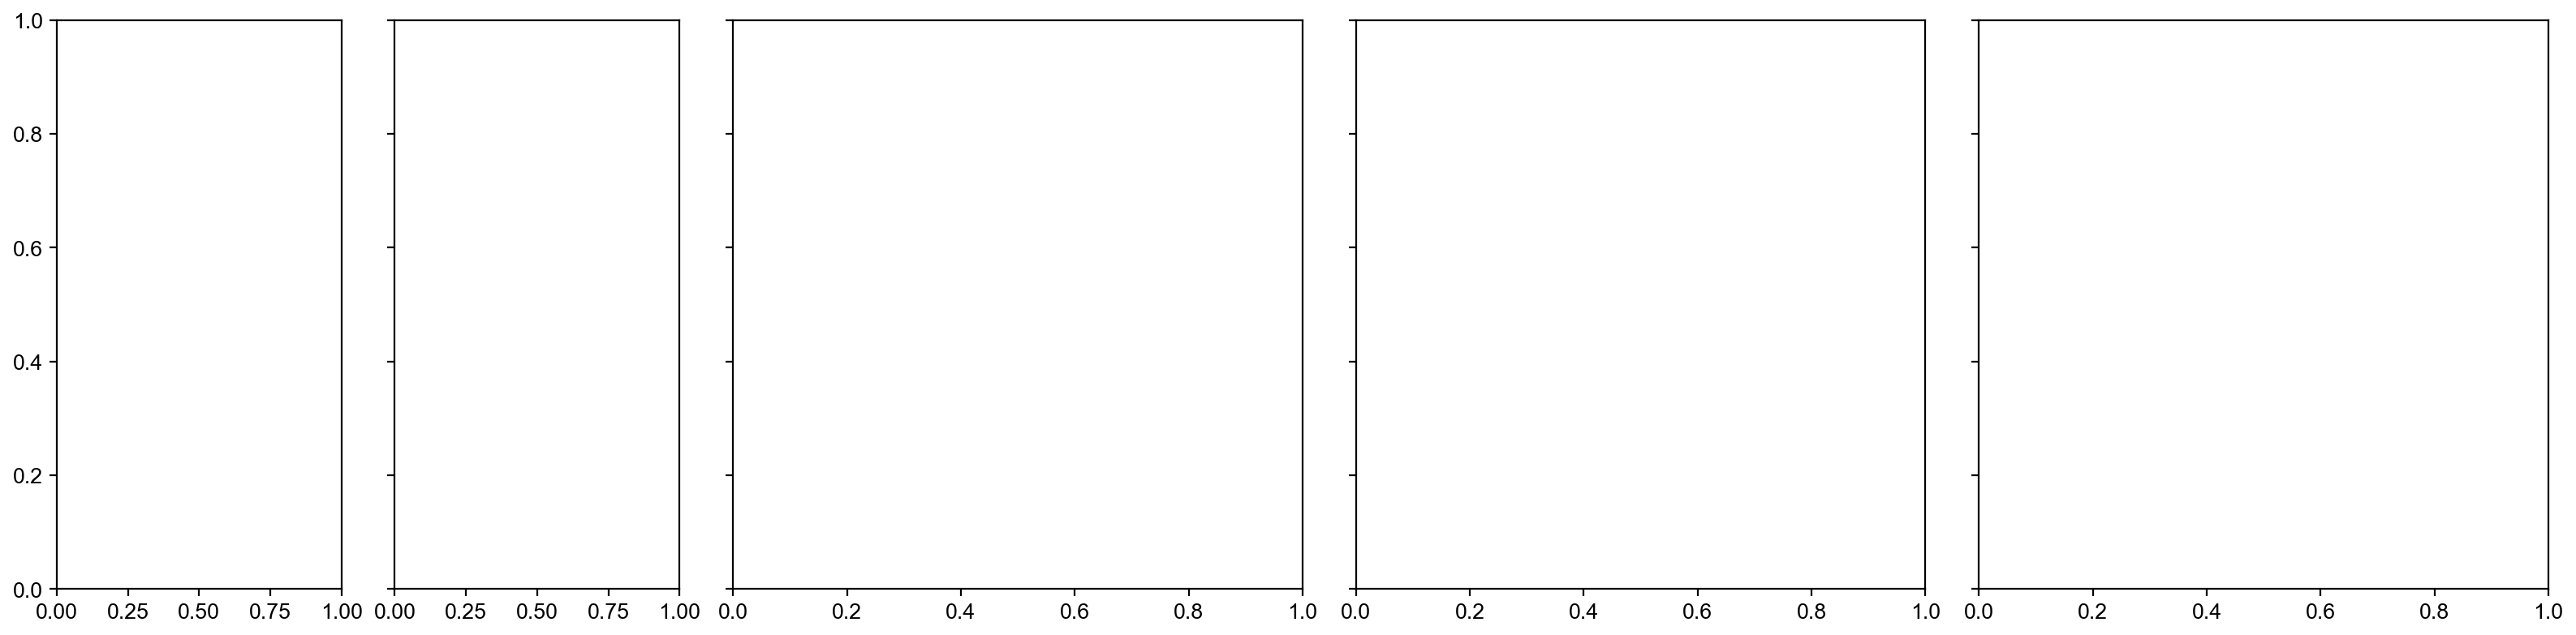

In [61]:
fig, axs = plt.subplots(1, 5, figsize=(20, 6), width_ratios=[0.5, 0.5, 1, 1, 1], sharey=True)
axs[0].set_box_aspect(2)
axs[1].set_box_aspect(2)
axs[2].set_box_aspect(1)
axs[3].set_box_aspect(1)
axs[4].set_box_aspect(1)
plt.tight_layout()